In [88]:
import os
import numpy as np
from scipy import stats

import torch

import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_theme()

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.data.face_detection import get_fair_face, get_utk
from source.utils.metrics import accuracy, aod, eod, spd, get_prs, get_tprs, get_fprs

os.makedirs(PLOTS_PATH, exist_ok=True)

In [89]:
method_seeds = [42, 142, 242, 342, 442]
dseed = 42

model = ["resnet18", "resnet34", "resnet50"][2]

targets = ["age", "gender", "race (old)", "race"]
# predicting race does not give high unfairness (with either pa) for eod and aod
# predicting gender also not too nice (only unfairness with age)
target = 1 # 0, 1, 2, 3
pa = 3 # 0, 1, 2, 3

In [90]:
# no need to define targets and protected attributes, are queried directly afterwards
ff_train_ds, ff_test_ds = get_fair_face(binarize=True, augment=False)
utk_test_ds = get_utk(binarize=True)

run_path = os.path.join(RESULTS_PATH, f"fairface_target{target}_{model}_mseed{method_seeds[0]}_dseed{dseed}")
fair_inds = torch.load(os.path.join(run_path, "fair_inds.pt"))
val_inds = torch.load(os.path.join(run_path, "val_inds.pt"))

print(len(fair_inds), len(val_inds), len(ff_test_ds), len(utk_test_ds))

# get targets and protected attributes
y_fair_t = ff_train_ds.targets[target, fair_inds]
a_fair_t = ff_train_ds.targets[pa, fair_inds]
y_val_t = ff_train_ds.targets[target, val_inds]
a_val_t = ff_train_ds.targets[pa, val_inds]
y_ff_test_t = ff_test_ds.targets[target]
a_ff_test_t = ff_test_ds.targets[pa]
y_utk_test_t = utk_test_ds.targets[target]
a_utk_test_t = utk_test_ds.targets[pa]

# get fraction of protected attribute for testsets
p_a_ff_test = a_ff_test_t.float().mean().item() * 100
p_a_utk_test = a_utk_test_t.float().mean().item() * 100
print(p_a_ff_test, p_a_utk_test)

# get fraction of targets for testsets
p_y_ff_test = y_ff_test_t.float().mean().item() * 100
p_y_utk_test = y_utk_test_t.float().mean().item() * 100
print(p_y_ff_test, p_y_utk_test)

10843 10843 10954 23705
19.034142792224884 42.5142377614975
52.875661849975586 52.27167010307312


In [91]:
# load probits
fair_probits, val_probits, ff_test_probits, utk_test_probits = list(), list(), list(), list()
for mseed in method_seeds:
    path = os.path.join(RESULTS_PATH, f"fairface_target{target}_{model}_mseed{mseed}_dseed{dseed}")

    fair_probits.append(torch.load(os.path.join(path, f"fair_probits_t{target}.pt")))
    val_probits.append(torch.load(os.path.join(path, f"val_probits_t{target}.pt")))
    ff_test_probits.append(torch.load(os.path.join(path, f"ff_test_probits_t{target}.pt")))
    utk_test_probits.append(torch.load(os.path.join(path, f"utk_test_probits_t{target}.pt")))

In [92]:
# calculate accuracies and fairness measures
fair_accs, val_accs, ff_test_accs, utk_test_accs = list(), list(), list(), list()
fair_spds, val_spds, ff_test_spds, utk_test_spds = list(), list(), list(), list()
fair_eods, val_eods, ff_test_eods, utk_test_eods = list(), list(), list(), list()
fair_aods, val_aods, ff_test_aods, utk_test_aods = list(), list(), list(), list()

for m in range(len(method_seeds)):
    fair_accs.append([accuracy(p.argmax(dim=1), y_fair_t) for p in fair_probits[m]])
    val_accs.append([accuracy(p.argmax(dim=1), y_val_t) for p in val_probits[m]])
    ff_test_accs.append([accuracy(p.argmax(dim=1), y_ff_test_t) for p in ff_test_probits[m]])
    utk_test_accs.append([accuracy(p.argmax(dim=1), y_utk_test_t) for p in utk_test_probits[m]])

    fair_spds.append([spd(p.argmax(dim=1), a_fair_t) for p in fair_probits[m]])
    val_spds.append([spd(p.argmax(dim=1), a_val_t) for p in val_probits[m]])
    ff_test_spds.append([spd(p.argmax(dim=1), a_ff_test_t) for p in ff_test_probits[m]])
    utk_test_spds.append([spd(p.argmax(dim=1), a_utk_test_t) for p in utk_test_probits[m]])
    
    fair_eods.append([eod(p.argmax(dim=1), y_fair_t, a_fair_t) for p in fair_probits[m]])
    val_eods.append([eod(p.argmax(dim=1), y_val_t, a_val_t) for p in val_probits[m]])
    ff_test_eods.append([eod(p.argmax(dim=1), y_ff_test_t, a_ff_test_t) for p in ff_test_probits[m]])
    utk_test_eods.append([eod(p.argmax(dim=1), y_utk_test_t, a_utk_test_t) for p in utk_test_probits[m]])

    fair_aods.append([aod(p.argmax(dim=1), y_fair_t, a_fair_t) for p in fair_probits[m]])
    val_aods.append([aod(p.argmax(dim=1), y_val_t, a_val_t) for p in val_probits[m]])
    ff_test_aods.append([aod(p.argmax(dim=1), y_ff_test_t, a_ff_test_t) for p in ff_test_probits[m]])
    utk_test_aods.append([aod(p.argmax(dim=1), y_utk_test_t, a_utk_test_t) for p in utk_test_probits[m]])

In [93]:
ff_test_m_accs, utk_test_m_accs = list(), list()
ff_test_m_spds, utk_test_m_spds = list(), list()
ff_test_m_eods, utk_test_m_eods = list(), list()
ff_test_m_aods, utk_test_m_aods = list(), list()

for m in range(len(method_seeds)):
    ff_test_m_accs.append(accuracy(torch.mean(ff_test_probits[m], dim=0).argmax(dim=1), y_ff_test_t))
    utk_test_m_accs.append(accuracy(torch.mean(utk_test_probits[m], dim=0).argmax(dim=1), y_utk_test_t))

    ff_test_m_spds.append(spd(torch.mean(ff_test_probits[m], dim=0).argmax(dim=1), a_ff_test_t))
    utk_test_m_spds.append(spd(torch.mean(utk_test_probits[m], dim=0).argmax(dim=1), a_utk_test_t))
    
    ff_test_m_eods.append(eod(torch.mean(ff_test_probits[m], dim=0).argmax(dim=1), y_ff_test_t, a_ff_test_t))
    utk_test_m_eods.append(eod(torch.mean(utk_test_probits[m], dim=0).argmax(dim=1), y_utk_test_t, a_utk_test_t))

    ff_test_m_aods.append(aod(torch.mean(ff_test_probits[m], dim=0).argmax(dim=1), y_ff_test_t, a_ff_test_t))
    utk_test_m_aods.append(aod(torch.mean(utk_test_probits[m], dim=0).argmax(dim=1), y_utk_test_t, a_utk_test_t))

In [94]:
# select the best temperature on validation set
temperatures = np.logspace(2, -6, 300)

optim_temps_spd, optim_temps_eod, optim_temps_aod = list(), list(), list()

for m in range(len(method_seeds)):

    best_temp_spd, best_temp_eod, best_temp_aod = temperatures[0], temperatures[0], temperatures[0]
    best_spd, best_eod, best_aod = float("inf"), float("inf"), float("inf")

    for temperature in temperatures:
    
        preds = torch.sum(val_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_spds[m])) / temperature, dim=0).reshape(-1, 1, 1), 
                        dim=0).argmax(dim=1)
        if np.abs(spd(preds, a_val_t)) < np.abs(best_spd):
            best_spd = spd(preds, a_val_t)
            best_temp_spd = temperature
        preds = torch.sum(val_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_eods[m])) / temperature, dim=0).reshape(-1, 1, 1),
                        dim=0).argmax(dim=1)
        if np.abs(eod(preds, y_val_t, a_val_t)) < np.abs(best_eod):
            best_eod = eod(preds, y_val_t, a_val_t)
            best_temp_eod = temperature
        preds = torch.sum(val_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_aods[m])) / temperature, dim=0).reshape(-1, 1, 1),
                        dim=0).argmax(dim=1)
        if np.abs(aod(preds, y_val_t, a_val_t)) < np.abs(best_aod):
            best_aod = aod(preds, y_val_t, a_val_t)
            best_temp_aod = temperature
    
    optim_temps_spd.append(best_temp_spd)
    optim_temps_eod.append(best_temp_eod)
    optim_temps_aod.append(best_temp_aod)

In [95]:
ff_test_fm_spd_accs, utk_test_fm_spd_accs = list(), list()
ff_test_fm_spds, utk_test_fm_spds = list(), list()
ff_test_fm_eod_accs, utk_test_fm_eod_accs = list(), list()
ff_test_fm_eods, utk_test_fm_eods = list(), list()
ff_test_fm_aod_accs, utk_test_fm_aod_accs = list(), list()
ff_test_fm_aods, utk_test_fm_aods = list(), list()

for m in range(len(method_seeds)):
    preds = torch.sum(ff_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_spds[m])) / optim_temps_spd[m], dim=0).reshape(-1, 1, 1), 
                      dim=0).argmax(dim=1)
    ff_test_fm_spd_accs.append(accuracy(preds, y_ff_test_t))
    ff_test_fm_spds.append(spd(preds, a_ff_test_t))
    preds = torch.sum(ff_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_eods[m])) / optim_temps_eod[m], dim=0).reshape(-1, 1, 1),
                        dim=0).argmax(dim=1)
    ff_test_fm_eod_accs.append(accuracy(preds, y_ff_test_t))
    ff_test_fm_eods.append(eod(preds, y_ff_test_t, a_ff_test_t))
    preds = torch.sum(ff_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_aods[m])) / optim_temps_aod[m], dim=0).reshape(-1, 1, 1),
                        dim=0).argmax(dim=1)
    ff_test_fm_aod_accs.append(accuracy(preds, y_ff_test_t))
    ff_test_fm_aods.append(aod(preds, y_ff_test_t, a_ff_test_t))

    preds = torch.sum(utk_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_spds[m])) / optim_temps_spd[m], dim=0).reshape(-1, 1, 1),
                        dim=0).argmax(dim=1)
    utk_test_fm_spd_accs.append(accuracy(preds, y_utk_test_t))
    utk_test_fm_spds.append(spd(preds, a_utk_test_t))
    preds = torch.sum(utk_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_eods[m])) / optim_temps_eod[m], dim=0).reshape(-1, 1, 1),
                        dim=0).argmax(dim=1)
    utk_test_fm_eod_accs.append(accuracy(preds, y_utk_test_t))
    utk_test_fm_eods.append(eod(preds, y_utk_test_t, a_utk_test_t))
    preds = torch.sum(utk_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_aods[m])) / optim_temps_aod[m], dim=0).reshape(-1, 1, 1),
                        dim=0).argmax(dim=1)
    utk_test_fm_aod_accs.append(accuracy(preds, y_utk_test_t))
    utk_test_fm_aods.append(aod(preds, y_utk_test_t, a_utk_test_t))

In [96]:
%%script false --no-raise-error

for m, mseed in enumerate(method_seeds):
    f, axs = plt.subplots(2, 3, figsize=(11, 5.2))
    axs[0, 0].scatter(ff_test_accs[m], ff_test_spds[m], c=val_spds[m], cmap="viridis_r")
    axs[0, 0].scatter(np.mean(ff_test_accs[m]), np.mean(ff_test_spds[m]), marker="*", c="black", s=150)
    axs[0, 0].scatter(ff_test_m_accs[m], ff_test_m_spds[m], marker="*", c="red", s=150)
    axs[0, 0].scatter(ff_test_fm_spd_accs[m], ff_test_fm_spds[m], marker="*", c="blue", s=150)
    axs[0, 0].set_ylabel("SPD")
    axs[0, 1].scatter(ff_test_accs[m], ff_test_eods[m], c=val_eods[m], cmap="viridis_r")
    axs[0, 1].scatter(np.mean(ff_test_accs[m]), np.mean(ff_test_eods[m]), marker="*", c="black", s=150)
    axs[0, 1].scatter(ff_test_m_accs[m], ff_test_m_eods[m], marker="*", c="red", s=150)
    axs[0, 1].scatter(ff_test_fm_eod_accs[m], ff_test_fm_eods[m], marker="*", c="blue", s=150)
    axs[0, 1].set_ylabel("EOD")
    axs[0, 2].scatter(ff_test_accs[m], ff_test_aods[m], c=val_aods[m], cmap="viridis_r")
    axs[0, 2].scatter(np.mean(ff_test_accs[m]), np.mean(ff_test_aods[m]), marker="*", c="black", s=150)
    axs[0, 2].scatter(ff_test_m_accs[m], ff_test_m_aods[m], marker="*", c="red", s=150)
    axs[0, 2].scatter(ff_test_fm_aod_accs[m], ff_test_fm_aods[m], marker="*", c="blue", s=150)
    axs[0, 2].set_ylabel("AOD")

    axs[1, 0].scatter(utk_test_accs[m], utk_test_spds[m], c=val_spds[m], cmap="viridis_r")
    axs[1, 0].scatter(np.mean(utk_test_accs[m]), np.mean(utk_test_spds[m]), marker="*", c="black", s=150)
    axs[1, 0].scatter(utk_test_m_accs[m], utk_test_m_spds[m], marker="*", c="red", s=150)
    axs[1, 0].scatter(utk_test_fm_spd_accs[m], utk_test_fm_spds[m], marker="*", c="blue", s=150)
    axs[1, 0].set_ylabel("SPD")
    axs[1, 1].scatter(utk_test_accs[m], utk_test_eods[m], c=val_eods[m], cmap="viridis_r")
    axs[1, 1].scatter(np.mean(utk_test_accs[m]), np.mean(utk_test_eods[m]), marker="*", c="black", s=150)
    axs[1, 1].scatter(utk_test_m_accs[m], utk_test_m_eods[m], marker="*", c="red", s=150)
    axs[1, 1].scatter(utk_test_fm_eod_accs[m], utk_test_fm_eods[m], marker="*", c="blue", s=150)
    axs[1, 1].set_ylabel("EOD")
    axs[1, 2].scatter(utk_test_accs[m], utk_test_aods[m], c=val_aods[m], cmap="viridis_r")
    axs[1, 2].scatter(np.mean(utk_test_accs[m]), np.mean(utk_test_aods[m]), marker="*", c="black", s=150)
    axs[1, 2].scatter(utk_test_m_accs[m], utk_test_m_aods[m], marker="*", c="red", s=150)
    axs[1, 2].scatter(utk_test_fm_aod_accs[m], utk_test_fm_aods[m], marker="*", c="blue", s=150)
    axs[1, 2].set_ylabel("AOD")

    axs[0, 1].set_title("FairFace")
    axs[1, 1].set_title("UTKFace")

    for ax in axs.flatten():
        ax.set_xlabel("Accuracy")
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.1f}"))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}".lstrip("0")))

    f.tight_layout()
    plt.show()

In [97]:
%%script false --no-raise-error

temperatures = np.logspace(2, -6, 300)

for m in range(len(method_seeds)):

    ff_test_fm_spd_accs, utk_test_fm_spd_accs = list(), list()
    ff_test_fm_spds, utk_test_fm_spds = list(), list()
    ff_test_fm_eod_accs, utk_test_fm_eod_accs = list(), list()
    ff_test_fm_eods, utk_test_fm_eods = list(), list()
    ff_test_fm_aod_accs, utk_test_fm_aod_accs = list(), list()
    ff_test_fm_aods, utk_test_fm_aods = list(), list()

    for temperature in temperatures:
    
        preds = torch.sum(ff_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_spds[m])) / temperature, dim=0).reshape(-1, 1, 1), 
                        dim=0).argmax(dim=1)
        ff_test_fm_spd_accs.append(accuracy(preds, y_ff_test_t))
        ff_test_fm_spds.append(spd(preds, a_ff_test_t))
        preds = torch.sum(ff_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_eods[m])) / temperature, dim=0).reshape(-1, 1, 1),
                            dim=0).argmax(dim=1)
        ff_test_fm_eod_accs.append(accuracy(preds, y_ff_test_t))
        ff_test_fm_eods.append(eod(preds, y_ff_test_t, a_ff_test_t))
        preds = torch.sum(ff_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_aods[m])) / temperature, dim=0).reshape(-1, 1, 1),
                            dim=0).argmax(dim=1)
        ff_test_fm_aod_accs.append(accuracy(preds, y_ff_test_t))
        ff_test_fm_aods.append(aod(preds, y_ff_test_t, a_ff_test_t))

        preds = torch.sum(utk_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_spds[m])) / temperature, dim=0).reshape(-1, 1, 1),
                            dim=0).argmax(dim=1)
        utk_test_fm_spd_accs.append(accuracy(preds, y_utk_test_t))
        utk_test_fm_spds.append(spd(preds, a_utk_test_t))
        preds = torch.sum(utk_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_eods[m])) / temperature, dim=0).reshape(-1, 1, 1),
                            dim=0).argmax(dim=1)
        utk_test_fm_eod_accs.append(accuracy(preds, y_utk_test_t))
        utk_test_fm_eods.append(eod(preds, y_utk_test_t, a_utk_test_t))
        preds = torch.sum(utk_test_probits[m] * torch.softmax(-torch.abs(torch.tensor(fair_aods[m])) / temperature, dim=0).reshape(-1, 1, 1),
                            dim=0).argmax(dim=1)
        utk_test_fm_aod_accs.append(accuracy(preds, y_utk_test_t))
        utk_test_fm_aods.append(aod(preds, y_utk_test_t, a_utk_test_t))

    acc_axs = list()
    f, axs = plt.subplots(2, 3, figsize=(12, 5.2), sharex=True)
    axs[0, 0].plot(temperatures, ff_test_fm_spds, "-")
    acc_axs.append(axs[0, 0].twinx())
    acc_axs[-1].plot(temperatures, ff_test_fm_spd_accs, "-", c="C1")
    axs[0, 0].vlines(optim_temps_spd[m], np.min(ff_test_fm_spds), np.max(ff_test_fm_spds), color="black", linestyle="--")
    axs[0, 0].set_ylabel("SPD", color="C0")
    axs[0, 1].plot(temperatures, ff_test_fm_eods, "-")
    acc_axs.append(axs[0, 1].twinx())
    acc_axs[-1].plot(temperatures, ff_test_fm_eod_accs, "-", c="C1")
    axs[0, 1].vlines(optim_temps_eod[m], np.min(ff_test_fm_eods), np.max(ff_test_fm_eods), color="black", linestyle="--")
    axs[0, 1].set_ylabel("EOD", color="C0")
    axs[0, 2].plot(temperatures, ff_test_fm_aods, "-")
    acc_axs.append(axs[0, 2].twinx())
    acc_axs[-1].plot(temperatures, ff_test_fm_aod_accs, "-", c="C1")
    axs[0, 2].vlines(optim_temps_aod[m], np.min(ff_test_fm_aods), np.max(ff_test_fm_aods), color="black", linestyle="--")
    axs[0, 2].set_ylabel("AOD", color="C0")

    axs[1, 0].plot(temperatures, utk_test_fm_spds, "-")
    acc_axs.append(axs[1, 0].twinx())
    acc_axs[-1].plot(temperatures, utk_test_fm_spd_accs, "-", c="C1")
    axs[1, 0].vlines(optim_temps_spd[m], np.min(utk_test_fm_spds), np.max(utk_test_fm_spds), color="black", linestyle="--")
    axs[1, 0].set_ylabel("SPD", color="C0")
    axs[1, 1].plot(temperatures, utk_test_fm_eods, "-")
    acc_axs.append(axs[1, 1].twinx())
    acc_axs[-1].plot(temperatures, utk_test_fm_eod_accs, "-", c="C1")
    axs[1, 1].vlines(optim_temps_eod[m], np.min(utk_test_fm_eods), np.max(utk_test_fm_eods), color="black", linestyle="--")
    axs[1, 1].set_ylabel("EOD", color="C0")
    axs[1, 2].plot(temperatures, utk_test_fm_aods, "-")
    acc_axs.append(axs[1, 2].twinx())
    acc_axs[-1].plot(temperatures, utk_test_fm_aod_accs, "-", c="C1")
    axs[1, 2].vlines(optim_temps_aod[m], np.min(utk_test_fm_aods), np.max(utk_test_fm_aods), color="black", linestyle="--")
    axs[1, 2].set_ylabel("AOD", color="C0")

    axs[0, 1].set_title("FairFace")
    axs[1, 1].set_title("UTKFace")


    for i, ax in enumerate(axs.flatten()):
        ax.yaxis.grid(False)
        if i >= 3:
            ax.set_xlabel("Temperature")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}".lstrip("0")))
        ax.set_xscale("log")
    for ax in acc_axs:
        ax.yaxis.grid(False)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.1f}"))
        ax.set_ylabel("Accuracy", color="C1")

    f.tight_layout()
    plt.show()

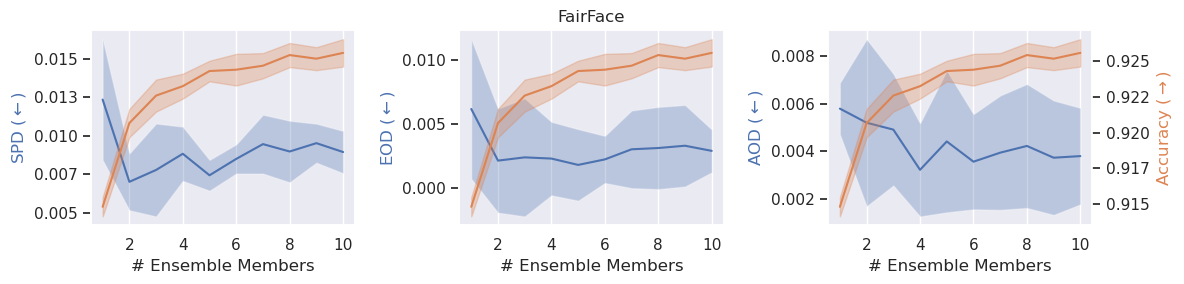

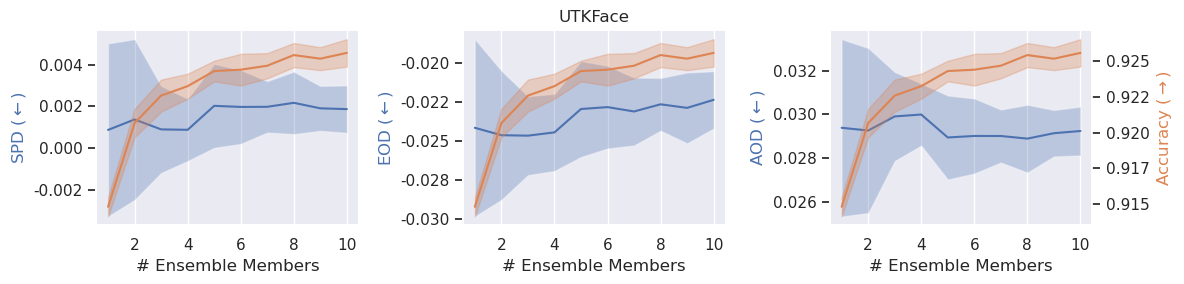

In [98]:
ensemble_members = list(range(1, len(ff_test_probits[0]) + 1))

ff_test_fm_accs, utk_test_fm_accs = list(), list()
ff_test_fm_spds, utk_test_fm_spds = list(), list()
ff_test_fm_eods, utk_test_fm_eods = list(), list()
ff_test_fm_aods, utk_test_fm_aods = list(), list()

for m in range(len(method_seeds)):

    ff_test_fm_accs_, utk_test_fm_accs_ = list(), list()
    ff_test_fm_spds_, utk_test_fm_spds_ = list(), list()
    ff_test_fm_eods_, utk_test_fm_eods_ = list(), list()
    ff_test_fm_aods_, utk_test_fm_aods_ = list(), list()

    for em in ensemble_members:
        preds = torch.mean(ff_test_probits[m][:em], dim=0).argmax(dim=1)
        ff_test_fm_accs_.append(accuracy(preds, y_ff_test_t))
        ff_test_fm_spds_.append(spd(preds, a_ff_test_t))
        ff_test_fm_eods_.append(eod(preds, y_ff_test_t, a_ff_test_t))
        ff_test_fm_aods_.append(aod(preds, y_ff_test_t, a_ff_test_t))

        preds = torch.mean(utk_test_probits[m][:em], dim=0).argmax(dim=1)
        utk_test_fm_accs_.append(accuracy(preds, y_utk_test_t))
        utk_test_fm_spds_.append(spd(preds, a_utk_test_t))
        utk_test_fm_eods_.append(eod(preds, y_utk_test_t, a_utk_test_t))
        utk_test_fm_aods_.append(aod(preds, y_utk_test_t, a_utk_test_t))

    ff_test_fm_accs.append(ff_test_fm_accs_)
    utk_test_fm_accs.append(utk_test_fm_accs_)
    ff_test_fm_spds.append(ff_test_fm_spds_)
    utk_test_fm_spds.append(utk_test_fm_spds_)
    ff_test_fm_eods.append(ff_test_fm_eods_)
    utk_test_fm_eods.append(utk_test_fm_eods_)
    ff_test_fm_aods.append(ff_test_fm_aods_)
    utk_test_fm_aods.append(utk_test_fm_aods_)

ff_test_fm_accs = np.asarray(ff_test_fm_accs)
utk_test_fm_accs = np.asarray(utk_test_fm_accs)
ff_test_fm_spds = np.asarray(ff_test_fm_spds)
utk_test_fm_spds = np.asarray(utk_test_fm_spds)
ff_test_fm_eods = np.asarray(ff_test_fm_eods)
utk_test_fm_eods = np.asarray(utk_test_fm_eods)
ff_test_fm_aods = np.asarray(ff_test_fm_aods)
utk_test_fm_aods = np.asarray(utk_test_fm_aods)


# FairFace Plotting
acc_axs = list()
f, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(ensemble_members, np.mean(ff_test_fm_spds, axis=0), "-")
axs[0].fill_between(ensemble_members, 
                   np.mean(ff_test_fm_spds, axis=0) - np.std(ff_test_fm_spds, axis=0), 
                   np.mean(ff_test_fm_spds, axis=0) + np.std(ff_test_fm_spds, axis=0), alpha=0.3)
acc_axs.append(axs[0].twinx())
axs[0].set_ylabel("SPD ($\\leftarrow$)", color="C0")
axs[1].plot(ensemble_members, np.mean(ff_test_fm_eods, axis=0), "-")
axs[1].fill_between(ensemble_members,
                   np.mean(ff_test_fm_eods, axis=0) - np.std(ff_test_fm_eods, axis=0), 
                   np.mean(ff_test_fm_eods, axis=0) + np.std(ff_test_fm_eods, axis=0), alpha=0.3)
acc_axs.append(axs[1].twinx())
axs[1].set_ylabel("EOD ($\\leftarrow$)", color="C0")
axs[2].plot(ensemble_members, np.mean(ff_test_fm_aods, axis=0), "-")
axs[2].fill_between(ensemble_members,
                   np.mean(ff_test_fm_aods, axis=0) - np.std(ff_test_fm_aods, axis=0), 
                   np.mean(ff_test_fm_aods, axis=0) + np.std(ff_test_fm_aods, axis=0), alpha=0.3)
acc_axs.append(axs[2].twinx())
axs[2].set_ylabel("AOD ($\\leftarrow$)", color="C0")

axs[1].set_title("FairFace")

for ax in axs:
    ax.yaxis.grid(False)
    ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
for a, ax in enumerate(acc_axs):
    ax.yaxis.grid(False)
    ax.plot(ensemble_members, np.mean(utk_test_fm_accs, axis=0), "-", c="C1")
    ax.fill_between(ensemble_members, 
                    np.mean(utk_test_fm_accs, axis=0) - np.std(utk_test_fm_accs, axis=0), 
                    np.mean(utk_test_fm_accs, axis=0) + np.std(utk_test_fm_accs, axis=0), alpha=0.3, color="C1")
    if a == 2:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        ax.set_ylabel("Accuracy ($\\rightarrow$)", color="C1")
    else:
        ax.set_yticks([])

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_ff.pdf"))
plt.show()

# UTKFace Plotting
acc_axs = list()
f, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(ensemble_members, np.mean(utk_test_fm_spds, axis=0), "-")
axs[0].fill_between(ensemble_members, 
                   np.mean(utk_test_fm_spds, axis=0) - np.std(utk_test_fm_spds, axis=0), 
                   np.mean(utk_test_fm_spds, axis=0) + np.std(utk_test_fm_spds, axis=0), alpha=0.3)
acc_axs.append(axs[0].twinx())
axs[0].set_ylabel("SPD ($\\leftarrow$)", color="C0")
axs[1].plot(ensemble_members, np.mean(utk_test_fm_eods, axis=0), "-")
axs[1].fill_between(ensemble_members,
                   np.mean(utk_test_fm_eods, axis=0) - np.std(utk_test_fm_eods, axis=0), 
                   np.mean(utk_test_fm_eods, axis=0) + np.std(utk_test_fm_eods, axis=0), alpha=0.3)
acc_axs.append(axs[1].twinx())
axs[1].set_ylabel("EOD ($\\leftarrow$)", color="C0")
axs[2].plot(ensemble_members, np.mean(utk_test_fm_aods, axis=0), "-")
axs[2].fill_between(ensemble_members,
                   np.mean(utk_test_fm_aods, axis=0) - np.std(utk_test_fm_aods, axis=0), 
                   np.mean(utk_test_fm_aods, axis=0) + np.std(utk_test_fm_aods, axis=0), alpha=0.3)
acc_axs.append(axs[2].twinx())
axs[2].set_ylabel("AOD ($\\leftarrow$)", color="C0")

axs[1].set_title("UTKFace")

for ax in axs:
    ax.yaxis.grid(False)
    ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
for a, ax in enumerate(acc_axs):
    ax.yaxis.grid(False)
    ax.plot(ensemble_members, np.mean(utk_test_fm_accs, axis=0), "-", c="C1")
    ax.fill_between(ensemble_members, 
                    np.mean(utk_test_fm_accs, axis=0) - np.std(utk_test_fm_accs, axis=0), 
                    np.mean(utk_test_fm_accs, axis=0) + np.std(utk_test_fm_accs, axis=0), alpha=0.3, color="C1")
    if a == 2:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        ax.set_ylabel("Accuracy ($\\rightarrow$)", color="C1")
    else:
        ax.set_yticks([])

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_utk.pdf"))
plt.show() 

In [99]:
# test for significance of disparate benefits
ff_test_fm_delta_accs = ff_test_fm_accs[:, -1] - np.mean(np.asarray(ff_test_accs), axis=1)
ff_test_fm_delta_spds = ff_test_fm_spds[:, -1] - np.mean(np.asarray(ff_test_spds), axis=1)
ff_test_fm_delta_eods = ff_test_fm_eods[:, -1] - np.mean(np.asarray(ff_test_eods), axis=1)
ff_test_fm_delta_aods = ff_test_fm_aods[:, -1] - np.mean(np.asarray(ff_test_aods), axis=1)
utk_test_fm_delta_accs = utk_test_fm_accs[:, -1] - np.mean(np.asarray(utk_test_accs), axis=1)
utk_test_fm_delta_spds = utk_test_fm_spds[:, -1] - np.mean(np.asarray(utk_test_spds), axis=1)
utk_test_fm_delta_eods = utk_test_fm_eods[:, -1] - np.mean(np.asarray(utk_test_eods), axis=1)
utk_test_fm_delta_aods = utk_test_fm_aods[:, -1] - np.mean(np.asarray(utk_test_aods), axis=1)
for s, samples in enumerate([utk_test_fm_delta_accs, ff_test_fm_delta_spds, ff_test_fm_delta_eods, ff_test_fm_delta_aods,
                            utk_test_fm_delta_accs, utk_test_fm_delta_spds, utk_test_fm_delta_eods, utk_test_fm_delta_aods]):
    # perform t-test for the null hypothesis that the mean of the samples is equal to zero
    t_statistic, p_value = stats.ttest_1samp(samples, 0)
    if p_value < 0.05:
        print(f"$\\boldsymbol{'{'}{np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}{'}'}$", end="")
    else:
        print(f"${np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}$", end="")
    if s % 4 < 3:
        print(" & ", end="")
    else:
        print(" \\\\")

$\boldsymbol{0.009_{\pm 0.001}}$ & $-0.001_{\pm 0.001}$ & $-0.000_{\pm 0.000}$ & $-0.002_{\pm 0.002}$ \\
$\boldsymbol{0.009_{\pm 0.001}}$ & $-0.000_{\pm 0.001}$ & $0.001_{\pm 0.002}$ & $0.001_{\pm 0.001}$ \\


In [100]:
for s, samples in enumerate([ff_test_fm_accs, ff_test_fm_spds, ff_test_fm_eods, ff_test_fm_aods]):
    print(f"${np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}$", end="")
    if s < 3:
        print(" & ", end="")
print(" \\\\")
for s, samples in enumerate([utk_test_fm_accs, utk_test_fm_spds, utk_test_fm_eods, utk_test_fm_aods]):
    print(f"${np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}$", end="")
    if s < 3:
        print(" & ", end="")
print(" \\\\")

$0.909_{\pm 0.004}$ & $0.009_{\pm 0.003}$ & $0.003_{\pm 0.004}$ & $0.004_{\pm 0.003}$ \\
$0.923_{\pm 0.003}$ & $0.002_{\pm 0.002}$ & $-0.023_{\pm 0.003}$ & $0.029_{\pm 0.002}$ \\


In [101]:
for s, samples in enumerate([np.mean(np.asarray(ff_test_accs), axis=1), 
                             np.mean(np.asarray(ff_test_spds), axis=1), 
                             np.mean(np.asarray(ff_test_eods), axis=1), 
                             np.mean(np.asarray(ff_test_aods), axis=1)]):
    print(f"${np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}$", end="")
    if s < 3:
        print(" & ", end="")
print(" \\\\")
for s, samples in enumerate([np.mean(np.asarray(utk_test_accs), axis=1), 
                             np.mean(np.asarray(utk_test_spds), axis=1), 
                             np.mean(np.asarray(utk_test_eods), axis=1), 
                             np.mean(np.asarray(utk_test_aods), axis=1)]):
    print(f"${np.mean(samples):.3f}_{'{'}\pm {np.std(samples):.3f}{'}'}$", end="")
    if s < 3:
        print(" & ", end="")
print(" \\\\")

$0.899_{\pm 0.001}$ & $0.010_{\pm 0.001}$ & $0.003_{\pm 0.001}$ & $0.006_{\pm 0.001}$ \\
$0.916_{\pm 0.001}$ & $0.002_{\pm 0.001}$ & $-0.023_{\pm 0.002}$ & $0.028_{\pm 0.001}$ \\


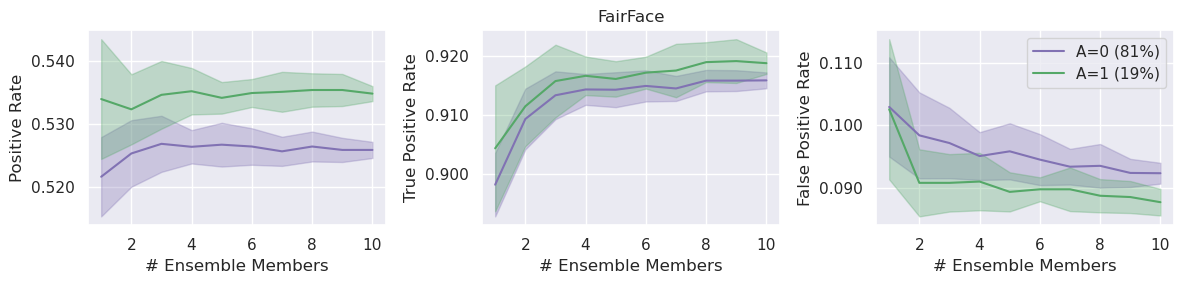

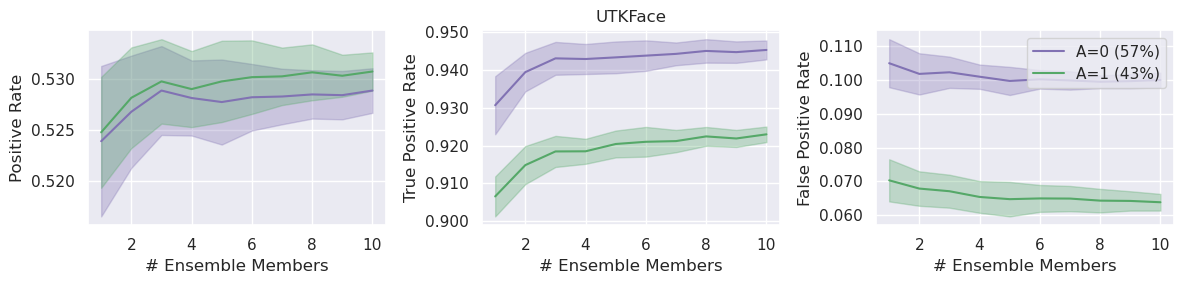

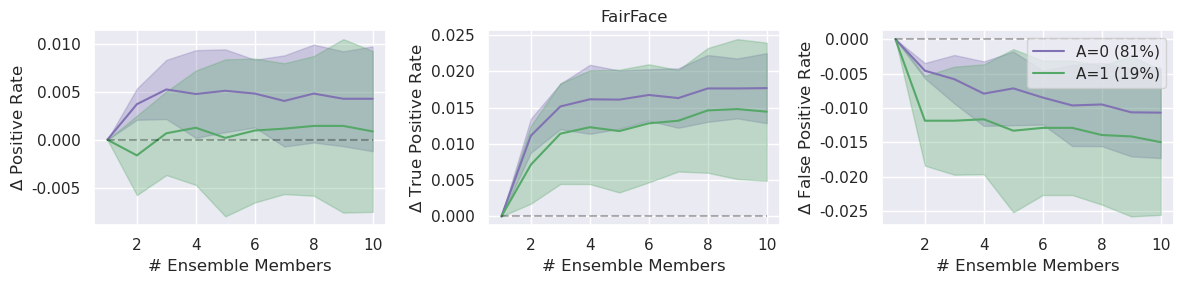

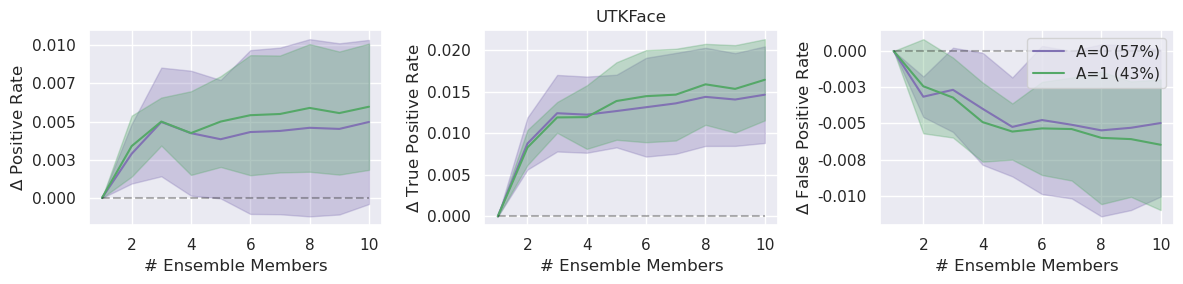

In [102]:
ensemble_members = list(range(1, len(ff_test_probits[0]) + 1))

for delta in [False, True]:

    ff_test_fm_prs_1, ff_test_fm_prs_0 = list(), list()
    ff_test_fm_tprs_1, ff_test_fm_tprs_0 = list(), list()
    ff_test_fm_fprs_1, ff_test_fm_fprs_0 = list(), list()
    utk_test_fm_prs_1, utk_test_fm_prs_0 = list(), list()
    utk_test_fm_tprs_1, utk_test_fm_tprs_0 = list(), list()
    utk_test_fm_fprs_1, utk_test_fm_fprs_0 = list(), list()

    for m in range(len(method_seeds)):

        ff_test_fm_prs_1_, ff_test_fm_prs_0_ = list(), list()
        ff_test_fm_tprs_1_, ff_test_fm_tprs_0_ = list(), list()
        ff_test_fm_fprs_1_, ff_test_fm_fprs_0_ = list(), list()
        utk_test_fm_prs_1_, utk_test_fm_prs_0_ = list(), list()
        utk_test_fm_tprs_1_, utk_test_fm_tprs_0_ = list(), list()
        utk_test_fm_fprs_1_, utk_test_fm_fprs_0_ = list(), list()

        for em in ensemble_members:
            preds = torch.mean(ff_test_probits[m][:em], dim=0).argmax(dim=1)
            pr1, pr0 = get_prs(preds, a_ff_test_t)
            tpr1, tpr0 = get_tprs(preds, y_ff_test_t, a_ff_test_t)
            fpr1, fpr0 = get_fprs(preds, y_ff_test_t, a_ff_test_t)
            ff_test_fm_prs_1_.append(pr1)
            ff_test_fm_prs_0_.append(pr0)
            ff_test_fm_tprs_1_.append(tpr1)
            ff_test_fm_tprs_0_.append(tpr0)
            ff_test_fm_fprs_1_.append(fpr1)
            ff_test_fm_fprs_0_.append(fpr0)

            preds = torch.mean(utk_test_probits[m][:em], dim=0).argmax(dim=1)
            pr1, pr0 = get_prs(preds, a_utk_test_t)
            tpr1, tpr0 = get_tprs(preds, y_utk_test_t, a_utk_test_t)
            fpr1, fpr0 = get_fprs(preds, y_utk_test_t, a_utk_test_t)
            utk_test_fm_prs_1_.append(pr1)
            utk_test_fm_prs_0_.append(pr0)
            utk_test_fm_tprs_1_.append(tpr1)
            utk_test_fm_tprs_0_.append(tpr0)
            utk_test_fm_fprs_1_.append(fpr1)
            utk_test_fm_fprs_0_.append(fpr0)
            
        if delta:
            ff_test_fm_prs_1.append([t - ff_test_fm_prs_1_[0] for t in ff_test_fm_prs_1_])
            ff_test_fm_prs_0.append([t - ff_test_fm_prs_0_[0] for t in ff_test_fm_prs_0_])
            ff_test_fm_tprs_1.append([t - ff_test_fm_tprs_1_[0] for t in ff_test_fm_tprs_1_])
            ff_test_fm_tprs_0.append([t - ff_test_fm_tprs_0_[0] for t in ff_test_fm_tprs_0_])
            ff_test_fm_fprs_1.append([t - ff_test_fm_fprs_1_[0] for t in ff_test_fm_fprs_1_])
            ff_test_fm_fprs_0.append([t - ff_test_fm_fprs_0_[0] for t in ff_test_fm_fprs_0_])

            utk_test_fm_prs_1.append([t - utk_test_fm_prs_1_[0] for t in utk_test_fm_prs_1_])
            utk_test_fm_prs_0.append([t - utk_test_fm_prs_0_[0] for t in utk_test_fm_prs_0_])
            utk_test_fm_tprs_1.append([t - utk_test_fm_tprs_1_[0] for t in utk_test_fm_tprs_1_])
            utk_test_fm_tprs_0.append([t - utk_test_fm_tprs_0_[0] for t in utk_test_fm_tprs_0_])
            utk_test_fm_fprs_1.append([t - utk_test_fm_fprs_1_[0] for t in utk_test_fm_fprs_1_])
            utk_test_fm_fprs_0.append([t - utk_test_fm_fprs_0_[0] for t in utk_test_fm_fprs_0_])
        else:
            ff_test_fm_prs_1.append(ff_test_fm_prs_1_)
            ff_test_fm_prs_0.append(ff_test_fm_prs_0_)
            ff_test_fm_tprs_1.append(ff_test_fm_tprs_1_)
            ff_test_fm_tprs_0.append(ff_test_fm_tprs_0_)
            ff_test_fm_fprs_1.append(ff_test_fm_fprs_1_)
            ff_test_fm_fprs_0.append(ff_test_fm_fprs_0_)

            utk_test_fm_prs_1.append(utk_test_fm_prs_1_)
            utk_test_fm_prs_0.append(utk_test_fm_prs_0_)
            utk_test_fm_tprs_1.append(utk_test_fm_tprs_1_)
            utk_test_fm_tprs_0.append(utk_test_fm_tprs_0_)
            utk_test_fm_fprs_1.append(utk_test_fm_fprs_1_)
            utk_test_fm_fprs_0.append(utk_test_fm_fprs_0_)

    ff_test_fm_prs_1 = np.asarray(ff_test_fm_prs_1)
    ff_test_fm_prs_0 = np.asarray(ff_test_fm_prs_0)
    ff_test_fm_tprs_1 = np.asarray(ff_test_fm_tprs_1)
    ff_test_fm_tprs_0 = np.asarray(ff_test_fm_tprs_0)
    ff_test_fm_fprs_1 = np.asarray(ff_test_fm_fprs_1)
    ff_test_fm_fprs_0 = np.asarray(ff_test_fm_fprs_0)

    utk_test_fm_prs_1 = np.asarray(utk_test_fm_prs_1)
    utk_test_fm_prs_0 = np.asarray(utk_test_fm_prs_0)
    utk_test_fm_tprs_1 = np.asarray(utk_test_fm_tprs_1)
    utk_test_fm_tprs_0 = np.asarray(utk_test_fm_tprs_0)
    utk_test_fm_fprs_1 = np.asarray(utk_test_fm_fprs_1)
    utk_test_fm_fprs_0 = np.asarray(utk_test_fm_fprs_0)

    f, axs = plt.subplots(1, 3, figsize=(12, 3))
    for t, test_pr in enumerate([ff_test_fm_prs_0, ff_test_fm_prs_1]):
        axs[0].plot(ensemble_members, np.mean(test_pr, axis=0), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)")
        axs[0].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[0].set_ylabel("$\Delta$ Positive Rate" if delta else "Positive Rate")
    for t, test_tpr in enumerate([ff_test_fm_tprs_0, ff_test_fm_tprs_1]):
        axs[1].plot(ensemble_members, np.mean(test_tpr, axis=0), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)")
        axs[1].fill_between(ensemble_members,
                            np.mean(test_tpr, axis=0) - np.std(test_tpr, axis=0), 
                            np.mean(test_tpr, axis=0) + np.std(test_tpr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[1].set_ylabel("$\Delta$ True Positive Rate" if delta else "True Positive Rate")
    for t, test_fpr in enumerate([ff_test_fm_fprs_0, ff_test_fm_fprs_1]):
        axs[2].plot(ensemble_members, np.mean(test_fpr, axis=0), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)")
        axs[2].fill_between(ensemble_members,
                            np.mean(test_fpr, axis=0) - np.std(test_fpr, axis=0), 
                            np.mean(test_fpr, axis=0) + np.std(test_fpr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[2].set_ylabel("$\Delta$ False Positive Rate" if delta else "False Positive Rate")
    axs[2].legend(loc="upper right")

    axs[1].set_title("FairFace")


    for i, ax in enumerate(axs.flatten()):
        # ax.yaxis.grid(False)
        ax.set_xlabel("# Ensemble Members")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        if delta:
            ax.hlines(0, 1, len(ensemble_members), color="black", linestyle="--", alpha=0.3)

    f.tight_layout()
    if delta:
        plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_delta_rates_ff.pdf"))
    else:
        plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_rates_ff.pdf"))
    plt.show()



    f, axs = plt.subplots(1, 3, figsize=(12, 3))
    for t, test_pr in enumerate([utk_test_fm_prs_0, utk_test_fm_prs_1]):
        axs[0].plot(ensemble_members, np.mean(test_pr, axis=0), "-", color=["C4", "C2"][t], 
                       label=f"A={t} ({(p_a_utk_test if t == 1 else 100 - p_a_utk_test):.0f}%)")
        axs[0].fill_between(ensemble_members, 
                            np.mean(test_pr, axis=0) - np.std(test_pr, axis=0), 
                            np.mean(test_pr, axis=0) + np.std(test_pr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[0].set_ylabel("$\Delta$ Positive Rate" if delta else "Positive Rate")
    for t, test_tpr in enumerate([utk_test_fm_tprs_0, utk_test_fm_tprs_1]):
        axs[1].plot(ensemble_members, np.mean(test_tpr, axis=0), "-", color=["C4", "C2"][t], 
                       label=f"A={t} ({(p_a_utk_test if t == 1 else 100 - p_a_utk_test):.0f}%)")
        axs[1].fill_between(ensemble_members,
                            np.mean(test_tpr, axis=0) - np.std(test_tpr, axis=0), 
                            np.mean(test_tpr, axis=0) + np.std(test_tpr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[1].set_ylabel("$\Delta$ True Positive Rate" if delta else "True Positive Rate")
    for t, test_fpr in enumerate([utk_test_fm_fprs_0, utk_test_fm_fprs_1]):
        axs[2].plot(ensemble_members, np.mean(test_fpr, axis=0), "-", color=["C4", "C2"][t], 
                       label=f"A={t} ({(p_a_utk_test if t == 1 else 100 - p_a_utk_test):.0f}%)")
        axs[2].fill_between(ensemble_members,
                            np.mean(test_fpr, axis=0) - np.std(test_fpr, axis=0), 
                            np.mean(test_fpr, axis=0) + np.std(test_fpr, axis=0), color=["C4", "C2"][t], alpha=0.3)
    axs[2].set_ylabel("$\Delta$ False Positive Rate" if delta else "False Positive Rate")
    axs[2].legend(loc="upper right")

    axs[1].set_title("UTKFace")


    for i, ax in enumerate(axs.flatten()):
        # ax.yaxis.grid(False)
        ax.set_xlabel("# Ensemble Members")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))
        if delta:
            ax.hlines(0, 1, len(ensemble_members), color="black", linestyle="--", alpha=0.3)

    f.tight_layout()
    if delta:
        plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_delta_rates_utk.pdf"))
    else:
        plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_rates_utk.pdf"))
    plt.show()

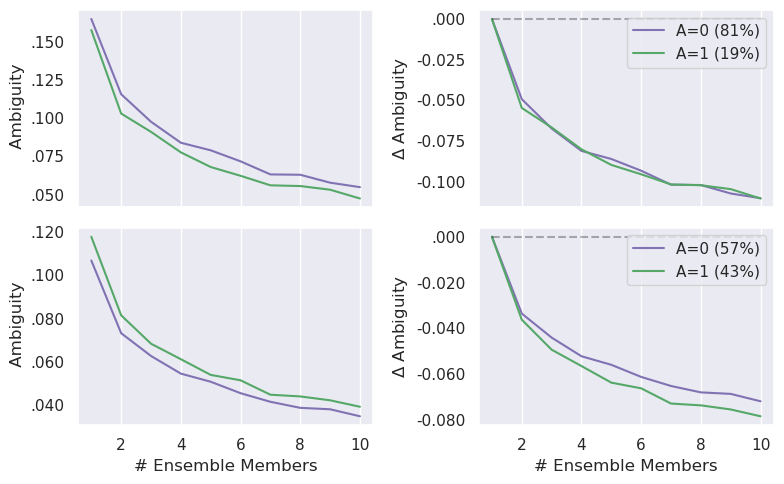

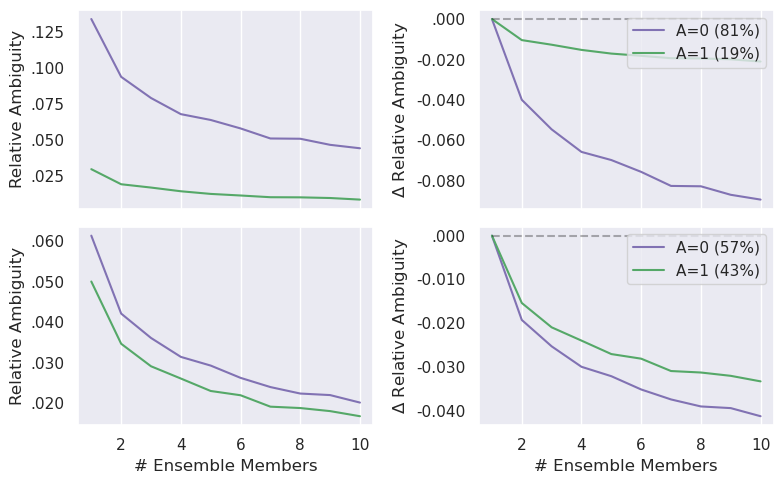

In [103]:
ensemble_members = list(range(1, len(ff_test_probits[0]) + 1))

for relative in [False, True]:

    f, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=True)

    if relative:
        factors_ff = [(100 - p_a_ff_test) / 100, p_a_ff_test / 100]
        factors_utk = [(100 - p_a_utk_test) / 100, p_a_utk_test / 100]
    else:
        factors_ff = [1, 1]
        factors_utk = [1, 1]

    for delta in [False, True]:

        ff_test_m_arb_a1, ff_test_m_arb_a0 = list(), list()
        utk_test_m_arb_a1, utk_test_m_arb_a0 = list(), list()

        for em in ensemble_members:
            probits = torch.stack(ff_test_probits)
            S, M, N, P = probits.shape
            preds = torch.mean(probits[:, :em], dim=1).argmax(dim=2).sum(dim=0)
            ambiguity = ((preds != S) & (preds != 0)).float()

            ff_test_m_arb_a1.append(ambiguity[a_ff_test_t == 1].mean() * factors_ff[1])
            ff_test_m_arb_a0.append(ambiguity[a_ff_test_t == 0].mean() * factors_ff[0])

            probits = torch.stack(utk_test_probits)
            preds = torch.mean(probits[:, :em], dim=1).argmax(dim=2).sum(dim=0)
            ambiguity = ((preds != S) & (preds != 0)).float()
            utk_test_m_arb_a1.append(ambiguity[a_utk_test_t == 1].mean() * factors_utk[1])
            utk_test_m_arb_a0.append(ambiguity[a_utk_test_t == 0].mean() * factors_utk[0])

        if delta:
            orig = ff_test_m_arb_a1[0]
            ff_test_m_arb_a1 = [t - orig for t in ff_test_m_arb_a1]
            orig = ff_test_m_arb_a0[0]
            ff_test_m_arb_a0 = [t - orig for t in ff_test_m_arb_a0]

            orig = utk_test_m_arb_a1[0]
            utk_test_m_arb_a1 = [t - orig for t in utk_test_m_arb_a1]
            orig = utk_test_m_arb_a0[0]
            utk_test_m_arb_a0 = [t - orig for t in utk_test_m_arb_a0]

            for t, test_pr in enumerate([ff_test_m_arb_a0, ff_test_m_arb_a1]):
                axs[0, 1].plot(ensemble_members, test_pr, "-", color=["C4", "C2"][t], 
                            label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)")
                axs[0, 1].set_ylabel(f"$\Delta${' Relative' if relative else ''} Ambiguity")
            axs[0, 1].hlines(0, 1, len(ensemble_members), color="black", linestyle="--", alpha=0.3)
            axs[0, 1].legend(loc="upper right")
            for t, test_pr in enumerate([utk_test_m_arb_a0, utk_test_m_arb_a1]):
                axs[1, 1].plot(ensemble_members, test_pr, "-", color=["C4", "C2"][t], 
                            label=f"A={t} ({(p_a_utk_test if t == 1 else 100 - p_a_utk_test):.0f}%)")
                axs[1, 1].set_ylabel(f"$\Delta${' Relative' if relative else ''} Ambiguity")
            axs[1, 1].hlines(0, 1, len(ensemble_members), color="black", linestyle="--", alpha=0.3)
            axs[1, 1].legend(loc="upper right")
        else:
            for t, test_pr in enumerate([ff_test_m_arb_a0, ff_test_m_arb_a1]):
                axs[0, 0].plot(ensemble_members, test_pr, "-", color=["C4", "C2"][t], 
                            label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)")
                axs[0, 0].set_ylabel(f"{'Relative' if relative else ''} Ambiguity")
            for t, test_pr in enumerate([utk_test_m_arb_a0, utk_test_m_arb_a1]):
                axs[1, 0].plot(ensemble_members, test_pr, "-", color=["C4", "C2"][t], 
                            label=f"A={t} ({(p_a_utk_test if t == 1 else 100 - p_a_utk_test):.0f}%)")
                axs[1, 0].set_ylabel(f"{'Relative' if relative else ''} Ambiguity")

    for i, ax in enumerate(axs.flatten()):
        ax.yaxis.grid(False)
        if i >= 2:
            ax.set_xlabel("# Ensemble Members")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}".lstrip("0")))



    f.tight_layout()
    plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_{'relative_' if relative else ''}ambiguity_a.pdf"))
    plt.show()

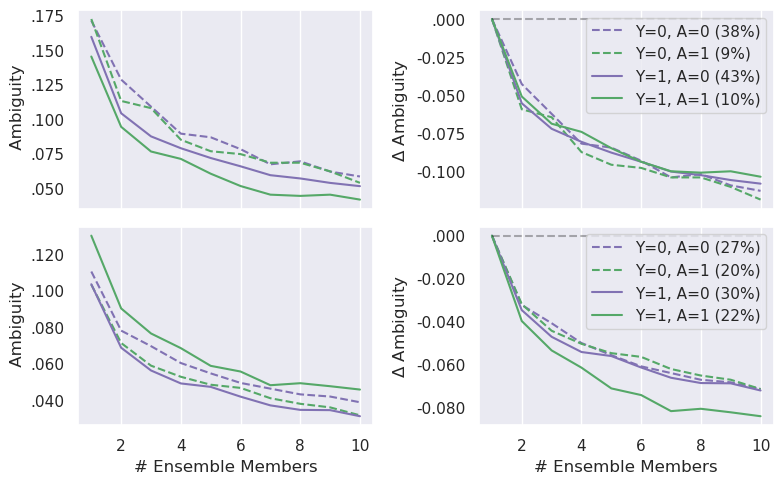

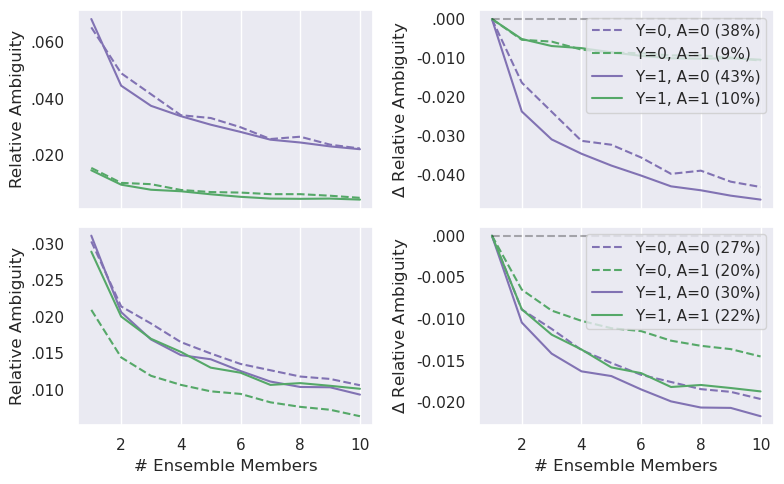

In [104]:
ensemble_members = list(range(1, len(ff_test_probits[0]) + 1))

for relative in [False, True]:

    f, axs = plt.subplots(2, 2, figsize=(8, 5), sharex=True)

    if relative:
        factors_ff = [[((100 - p_a_ff_test) / 100) * ((100 - p_y_ff_test) / 100), (p_a_ff_test / 100) * ((100 - p_y_ff_test) / 100)],
                      [((100 - p_a_ff_test) / 100) * (p_y_ff_test / 100), (p_a_ff_test / 100) * (p_y_ff_test / 100)]]
        factors_utk = [[((100 - p_a_utk_test) / 100) * ((100 - p_y_utk_test) / 100), (p_a_utk_test / 100) * ((100 - p_y_utk_test) / 100)],
                       [((100 - p_a_utk_test) / 100) * (p_y_utk_test / 100), (p_a_utk_test / 100) * (p_y_utk_test / 100)]]
    else:
        factors_ff = [[1, 1], [1, 1]]
        factors_utk = [[1, 1], [1, 1]]

    for delta in [False, True]:

        ff_test_m_arb_y1_a1, ff_test_m_arb_y0_a1, ff_test_m_arb_y1_a0, ff_test_m_arb_y0_a0 = list(), list(), list(), list()
        utk_test_m_arb_y1_a1, utk_test_m_arb_y0_a1, utk_test_m_arb_y1_a0, utk_test_m_arb_y0_a0 = list(), list(), list(), list()

        for em in ensemble_members:
            probits = torch.stack(ff_test_probits)
            S, M, N, P = probits.shape
            preds = torch.mean(probits[:, :em], dim=1).argmax(dim=2).sum(dim=0)
            ambiguity = ((preds != S) & (preds != 0)).float()

            ff_test_m_arb_y1_a1.append(ambiguity[(y_ff_test_t == 1) & (a_ff_test_t == 1)].mean() * factors_ff[1][1])
            ff_test_m_arb_y0_a1.append(ambiguity[(y_ff_test_t == 0) & (a_ff_test_t == 1)].mean() * factors_ff[0][1])
            ff_test_m_arb_y1_a0.append(ambiguity[(y_ff_test_t == 1) & (a_ff_test_t == 0)].mean() * factors_ff[1][0])
            ff_test_m_arb_y0_a0.append(ambiguity[(y_ff_test_t == 0) & (a_ff_test_t == 0)].mean() * factors_ff[0][0])

            probits = torch.stack(utk_test_probits)
            preds = torch.mean(probits[:, :em], dim=1).argmax(dim=2).sum(dim=0)
            ambiguity = ((preds != S) & (preds != 0)).float()
            utk_test_m_arb_y1_a1.append(ambiguity[(y_utk_test_t == 1) & (a_utk_test_t == 1)].mean() * factors_utk[1][1])
            utk_test_m_arb_y0_a1.append(ambiguity[(y_utk_test_t == 0) & (a_utk_test_t == 1)].mean() * factors_utk[0][1])
            utk_test_m_arb_y1_a0.append(ambiguity[(y_utk_test_t == 1) & (a_utk_test_t == 0)].mean() * factors_utk[1][0])
            utk_test_m_arb_y0_a0.append(ambiguity[(y_utk_test_t == 0) & (a_utk_test_t == 0)].mean() * factors_utk[0][0])

        if delta:
            orig = ff_test_m_arb_y1_a1[0]
            ff_test_m_arb_y1_a1 = [t - orig for t in ff_test_m_arb_y1_a1]
            orig = ff_test_m_arb_y0_a1[0]
            ff_test_m_arb_y0_a1 = [t - orig for t in ff_test_m_arb_y0_a1]
            orig = ff_test_m_arb_y1_a0[0]
            ff_test_m_arb_y1_a0 = [t - orig for t in ff_test_m_arb_y1_a0]
            orig = ff_test_m_arb_y0_a0[0]
            ff_test_m_arb_y0_a0 = [t - orig for t in ff_test_m_arb_y0_a0]

            orig = utk_test_m_arb_y1_a1[0]
            utk_test_m_arb_y1_a1 = [t - orig for t in utk_test_m_arb_y1_a1]
            orig = utk_test_m_arb_y0_a1[0]
            utk_test_m_arb_y0_a1 = [t - orig for t in utk_test_m_arb_y0_a1]
            orig = utk_test_m_arb_y1_a0[0]
            utk_test_m_arb_y1_a0 = [t - orig for t in utk_test_m_arb_y1_a0]
            orig = utk_test_m_arb_y0_a0[0]
            utk_test_m_arb_y0_a0 = [t - orig for t in utk_test_m_arb_y0_a0]

            for t, test_pr in enumerate([ff_test_m_arb_y0_a0, ff_test_m_arb_y0_a1]):
                axs[0, 1].plot(ensemble_members, test_pr, "--", color=["C4", "C2"][t], 
                            label=f"Y=0, A={t} ({((100 - p_y_ff_test) * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
            for t, test_pr in enumerate([ff_test_m_arb_y1_a0, ff_test_m_arb_y1_a1]):
                axs[0, 1].plot(ensemble_members, test_pr, "-", color=["C4", "C2"][t], 
                            label=f"Y=1, A={t} ({(p_y_ff_test * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
            axs[0, 1].set_ylabel(f"$\Delta${' Relative' if relative else ''} Ambiguity")
            axs[0, 1].hlines(0, 1, len(ensemble_members), color="black", linestyle="--", alpha=0.3)
            axs[0, 1].legend(loc="upper right")
            for t, test_pr in enumerate([utk_test_m_arb_y0_a0, utk_test_m_arb_y0_a1]):
                axs[1, 1].plot(ensemble_members, test_pr, "--", color=["C4", "C2"][t], 
                            label=f"Y=0, A={t} ({((100 - p_y_utk_test) * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
            for t, test_pr in enumerate([utk_test_m_arb_y1_a0, utk_test_m_arb_y1_a1]):
                axs[1, 1].plot(ensemble_members, test_pr, "-", color=["C4", "C2"][t], 
                            label=f"Y=1, A={t} ({(p_y_utk_test * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
            axs[1, 1].set_ylabel(f"$\Delta${' Relative' if relative else ''} Ambiguity")
            axs[1, 1].hlines(0, 1, len(ensemble_members), color="black", linestyle="--", alpha=0.3)
            axs[1, 1].legend(loc="upper right")
        else:
            for t, test_pr in enumerate([ff_test_m_arb_y0_a0, ff_test_m_arb_y0_a1]):
                axs[0, 0].plot(ensemble_members, test_pr, "--", color=["C4", "C2"][t], 
                            label=f"Y=0, A={t} ({((100 - p_y_ff_test) * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
            axs[0, 0].set_ylabel(f"{'Relative' if relative else ''} Ambiguity")
            for t, test_pr in enumerate([ff_test_m_arb_y1_a0, ff_test_m_arb_y1_a1]):
                axs[0, 0].plot(ensemble_members, test_pr, "-", color=["C4", "C2"][t], 
                            label=f"Y=1, A={t} ({(p_y_ff_test * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
            for t, test_pr in enumerate([utk_test_m_arb_y0_a0, utk_test_m_arb_y0_a1]):
                axs[1, 0].plot(ensemble_members, test_pr, "--", color=["C4", "C2"][t], 
                            label=f"Y=0, A={t} ({((100 - p_y_utk_test) * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
            for t, test_pr in enumerate([utk_test_m_arb_y1_a0, utk_test_m_arb_y1_a1]):
                axs[1, 0].plot(ensemble_members, test_pr, "-", color=["C4", "C2"][t], 
                            label=f"Y=1, A={t} ({(p_y_utk_test * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
            axs[1, 0].set_ylabel(f"{'Relative' if relative else ''} Ambiguity")

    for i, ax in enumerate(axs.flatten()):
        ax.yaxis.grid(False)
        if i >= 2:
            ax.set_xlabel("# Ensemble Members")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}".lstrip("0")))



    f.tight_layout()
    plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_{'relative_' if relative else ''}ambiguity_ya.pdf"))
    plt.show()

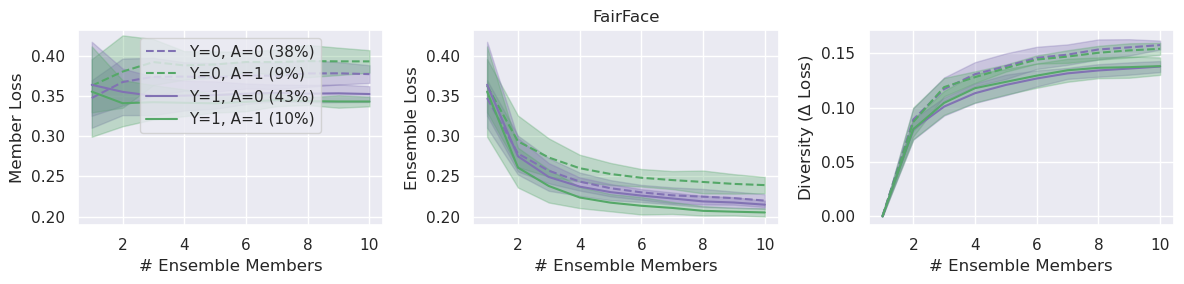

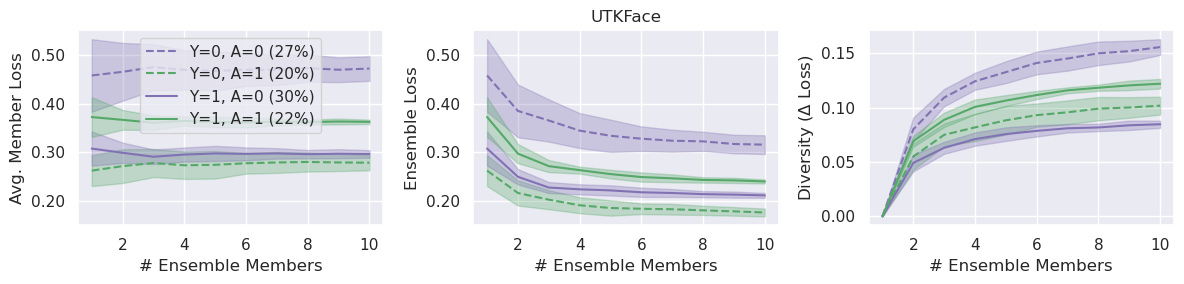

In [105]:
ensemble_members = list(range(1, len(ff_test_probits[0]) + 1))
eps = 1e-10
    
ff_test_ens_loss_y0_a1, ff_test_ens_loss_y1_a1, ff_test_ens_loss_y0_a0, ff_test_ens_loss_y1_a0 = list(), list(), list(), list()
ff_test_member_loss_y0_a1, ff_test_member_loss_y1_a1, ff_test_member_loss_y0_a0, ff_test_member_loss_y1_a0 = list(), list(), list(), list()
ff_test_m_div_y0_a1, ff_test_m_div_y1_a1, ff_test_m_div_y0_a0, ff_test_m_div_y1_a0 = list(), list(), list(), list()
utk_test_ens_loss_y0_a1, utk_test_ens_loss_y1_a1, utk_test_ens_loss_y0_a0, utk_test_ens_loss_y1_a0 = list(), list(), list(), list()
utk_test_member_loss_y0_a1, utk_test_member_loss_y1_a1, utk_test_member_loss_y0_a0, utk_test_member_loss_y1_a0 = list(), list(), list(), list()
utk_test_m_div_y0_a1, utk_test_m_div_y1_a1, utk_test_m_div_y0_a0, utk_test_m_div_y1_a0 = list(), list(), list(), list()

for em in ensemble_members:
    probits = torch.stack(ff_test_probits)
    S, M, N, P = probits.shape
    preds = probits[:, :em]
    
    ens_loss = - torch.log(torch.gather(torch.mean(preds, dim=1, keepdim=True), dim=3, 
                                         index=y_ff_test_t.reshape(1, 1, -1, 1).expand_as(torch.mean(preds, dim=1, keepdim=True)[..., :1])))[:, 0][..., 0]

    ff_test_ens_loss_y1_a1.append(ens_loss[:, (y_ff_test_t == 1) & (a_ff_test_t == 1)].mean(dim=1))
    ff_test_ens_loss_y0_a1.append(ens_loss[:, (y_ff_test_t == 0) & (a_ff_test_t == 1)].mean(dim=1))
    ff_test_ens_loss_y1_a0.append(ens_loss[:, (y_ff_test_t == 1) & (a_ff_test_t == 0)].mean(dim=1))
    ff_test_ens_loss_y0_a0.append(ens_loss[:, (y_ff_test_t == 0) & (a_ff_test_t == 0)].mean(dim=1))

    member_loss = - torch.mean(torch.log(torch.gather(preds, dim=3, index=y_ff_test_t.reshape(1, 1, -1, 1).expand_as(preds[..., :1]))), dim=1)[..., 0]

    ff_test_member_loss_y1_a1.append(member_loss[:, (y_ff_test_t == 1) & (a_ff_test_t == 1)].mean(dim=1))
    ff_test_member_loss_y0_a1.append(member_loss[:, (y_ff_test_t == 0) & (a_ff_test_t == 1)].mean(dim=1))
    ff_test_member_loss_y1_a0.append(member_loss[:, (y_ff_test_t == 1) & (a_ff_test_t == 0)].mean(dim=1))
    ff_test_member_loss_y0_a0.append(member_loss[:, (y_ff_test_t == 0) & (a_ff_test_t == 0)].mean(dim=1))

    diversity = torch.mean(torch.log(torch.gather(torch.mean(preds, dim=1, keepdim=True), dim=3, 
                                                    index=y_ff_test_t.reshape(1, 1, -1, 1).expand_as(torch.mean(preds, dim=1, keepdim=True)[..., :1])) / 
                                    (torch.gather(preds, dim=3, index=y_ff_test_t.reshape(1, 1, -1, 1).expand_as(preds[..., :1])) + eps))[..., 0], dim=1)
    ff_test_m_div_y1_a1.append(diversity[:, (y_ff_test_t == 1) & (a_ff_test_t == 1)].mean(dim=1))
    ff_test_m_div_y0_a1.append(diversity[:, (y_ff_test_t == 0) & (a_ff_test_t == 1)].mean(dim=1))
    ff_test_m_div_y1_a0.append(diversity[:, (y_ff_test_t == 1) & (a_ff_test_t == 0)].mean(dim=1))
    ff_test_m_div_y0_a0.append(diversity[:, (y_ff_test_t == 0) & (a_ff_test_t == 0)].mean(dim=1))


    probits = torch.stack(utk_test_probits)
    preds = probits[:, :em]
    
    ens_loss = - torch.log(torch.gather(torch.mean(preds, dim=1, keepdim=True), dim=3,
                                            index=y_utk_test_t.reshape(1, 1, -1, 1).expand_as(torch.mean(preds, dim=1, keepdim=True)[..., :1])))[:, 0][..., 0]
    
    utk_test_ens_loss_y1_a1.append(ens_loss[:, (y_utk_test_t == 1) & (a_utk_test_t == 1)].mean(dim=1))
    utk_test_ens_loss_y0_a1.append(ens_loss[:, (y_utk_test_t == 0) & (a_utk_test_t == 1)].mean(dim=1))
    utk_test_ens_loss_y1_a0.append(ens_loss[:, (y_utk_test_t == 1) & (a_utk_test_t == 0)].mean(dim=1))
    utk_test_ens_loss_y0_a0.append(ens_loss[:, (y_utk_test_t == 0) & (a_utk_test_t == 0)].mean(dim=1))

    member_loss = - torch.mean(torch.log(torch.gather(preds, dim=3, index=y_utk_test_t.reshape(1, 1, -1, 1).expand_as(preds[..., :1]))), dim=1)[..., 0]

    utk_test_member_loss_y1_a1.append(member_loss[:, (y_utk_test_t == 1) & (a_utk_test_t == 1)].mean(dim=1))
    utk_test_member_loss_y0_a1.append(member_loss[:, (y_utk_test_t == 0) & (a_utk_test_t == 1)].mean(dim=1))
    utk_test_member_loss_y1_a0.append(member_loss[:, (y_utk_test_t == 1) & (a_utk_test_t == 0)].mean(dim=1))
    utk_test_member_loss_y0_a0.append(member_loss[:, (y_utk_test_t == 0) & (a_utk_test_t == 0)].mean(dim=1))

    diversity = torch.mean(torch.log(torch.gather(torch.mean(preds, dim=1, keepdim=True), dim=3, 
                                                    index=y_utk_test_t.reshape(1, 1, -1, 1).expand_as(torch.mean(preds, dim=1, keepdim=True)[..., :1])) / 
                                    (torch.gather(preds, dim=3, index=y_utk_test_t.reshape(1, 1, -1, 1).expand_as(preds[..., :1])) + eps))[..., 0], dim=1)

    utk_test_m_div_y1_a1.append(diversity[:, (y_utk_test_t == 1) & (a_utk_test_t == 1)].mean(dim=1))
    utk_test_m_div_y0_a1.append(diversity[:, (y_utk_test_t == 0) & (a_utk_test_t == 1)].mean(dim=1))
    utk_test_m_div_y1_a0.append(diversity[:, (y_utk_test_t == 1) & (a_utk_test_t == 0)].mean(dim=1))
    utk_test_m_div_y0_a0.append(diversity[:, (y_utk_test_t == 0) & (a_utk_test_t == 0)].mean(dim=1))

ff_test_member_loss_y0_a1 = torch.stack(ff_test_member_loss_y0_a1)
ff_test_member_loss_y1_a1 = torch.stack(ff_test_member_loss_y1_a1)
ff_test_member_loss_y0_a0 = torch.stack(ff_test_member_loss_y0_a0)
ff_test_member_loss_y1_a0 = torch.stack(ff_test_member_loss_y1_a0)
ff_test_ens_loss_y0_a1 = torch.stack(ff_test_ens_loss_y0_a1)
ff_test_ens_loss_y1_a1 = torch.stack(ff_test_ens_loss_y1_a1)
ff_test_ens_loss_y0_a0 = torch.stack(ff_test_ens_loss_y0_a0)
ff_test_ens_loss_y1_a0 = torch.stack(ff_test_ens_loss_y1_a0)
ff_test_m_div_y0_a1 = torch.stack(ff_test_m_div_y0_a1)
ff_test_m_div_y1_a1 = torch.stack(ff_test_m_div_y1_a1)
ff_test_m_div_y0_a0 = torch.stack(ff_test_m_div_y0_a0)
ff_test_m_div_y1_a0 = torch.stack(ff_test_m_div_y1_a0)

utk_test_member_loss_y0_a1 = torch.stack(utk_test_member_loss_y0_a1)
utk_test_member_loss_y1_a1 = torch.stack(utk_test_member_loss_y1_a1)
utk_test_member_loss_y0_a0 = torch.stack(utk_test_member_loss_y0_a0)
utk_test_member_loss_y1_a0 = torch.stack(utk_test_member_loss_y1_a0)
utk_test_ens_loss_y0_a1 = torch.stack(utk_test_ens_loss_y0_a1)
utk_test_ens_loss_y1_a1 = torch.stack(utk_test_ens_loss_y1_a1)
utk_test_ens_loss_y0_a0 = torch.stack(utk_test_ens_loss_y0_a0)
utk_test_ens_loss_y1_a0 = torch.stack(utk_test_ens_loss_y1_a0)
utk_test_m_div_y0_a1 = torch.stack(utk_test_m_div_y0_a1)
utk_test_m_div_y1_a1 = torch.stack(utk_test_m_div_y1_a1)
utk_test_m_div_y0_a0 = torch.stack(utk_test_m_div_y0_a0)
utk_test_m_div_y1_a0 = torch.stack(utk_test_m_div_y1_a0)


f, axs = plt.subplots(1, 3, figsize=(12, 3))
for t, test_ent in enumerate([ff_test_member_loss_y0_a0, ff_test_member_loss_y0_a1]):
    axs[0].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_ff_test) * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
    axs[0].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([ff_test_member_loss_y1_a0, ff_test_member_loss_y1_a1]):
    axs[0].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({(p_y_ff_test * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
    axs[0].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[0].set_ylabel("Member Loss")
axs[0].legend(loc="upper center")

for t, test_ent in enumerate([ff_test_ens_loss_y0_a0, ff_test_ens_loss_y0_a1]):
    axs[1].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_ff_test) * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
    axs[1].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([ff_test_ens_loss_y1_a0, ff_test_ens_loss_y1_a1]):
    axs[1].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({(p_y_ff_test * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
    axs[1].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[1].set_ylabel("Ensemble Loss")

for t, test_ent in enumerate([ff_test_m_div_y0_a0, ff_test_m_div_y0_a1]):
    axs[2].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_ff_test) * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
    axs[2].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([ff_test_m_div_y1_a0, ff_test_m_div_y1_a1]):
    axs[2].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({(p_y_ff_test * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
    axs[2].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[2].set_ylabel("Diversity ($\Delta$ Loss)")

axs[1].set_title("FairFace")

for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))
    if i < 2:
        ax.set_ylim(min(axs[0].get_ylim()[0], axs[1].get_ylim()[0]),
                    max(axs[0].get_ylim()[1], axs[1].get_ylim()[1]))

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_losses_diversity_ff.pdf"))
plt.show()



f, axs = plt.subplots(1, 3, figsize=(12, 3))
for t, test_ent in enumerate([utk_test_member_loss_y0_a0, utk_test_member_loss_y0_a1]):
    axs[0].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_utk_test) * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
    axs[0].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([utk_test_member_loss_y1_a0, utk_test_member_loss_y1_a1]):
    axs[0].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({(p_y_utk_test * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
    axs[0].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[0].set_ylabel("Avg. Member Loss")
axs[0].legend(loc="upper center")

for t, test_ent in enumerate([utk_test_ens_loss_y0_a0, utk_test_ens_loss_y0_a1]):
    axs[1].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_utk_test) * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
    axs[1].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([utk_test_ens_loss_y1_a0, utk_test_ens_loss_y1_a1]):
    axs[1].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({(p_y_utk_test * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
    axs[1].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[1].set_ylabel("Ensemble Loss")

for t, test_ent in enumerate([utk_test_m_div_y0_a0, utk_test_m_div_y0_a1]):
    axs[2].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_utk_test) * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
    axs[2].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([utk_test_m_div_y1_a0, utk_test_m_div_y1_a1]):
    axs[2].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({(p_y_utk_test * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
    axs[2].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[2].set_ylabel("Diversity ($\Delta$ Loss)")

axs[1].set_title("UTKFace")

for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))
    if i < 2:
        ax.set_ylim(min(axs[0].get_ylim()[0], axs[1].get_ylim()[0]),
                    max(axs[0].get_ylim()[1], axs[1].get_ylim()[1]))

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_losses_diversity_utk.pdf"))
plt.show()

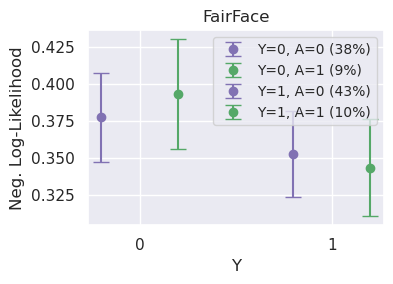

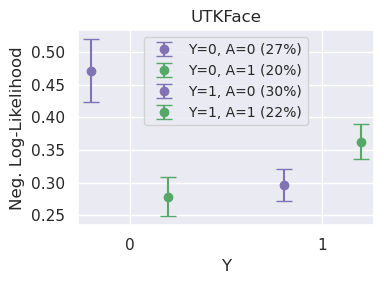

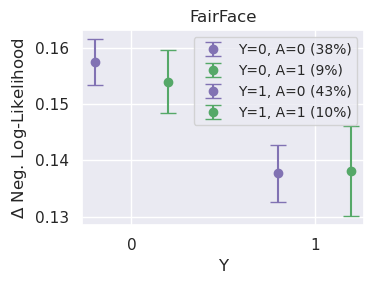

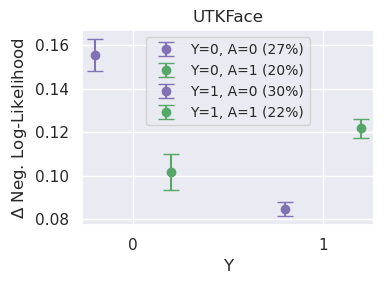

In [106]:
ff_test_member_loss_y0_a1, ff_test_member_loss_y1_a1, ff_test_member_loss_y0_a0, ff_test_member_loss_y1_a0 = list(), list(), list(), list()
ff_test_member_loss_a1, ff_test_member_loss_a0 = list(), list()
ff_test_ensemble_loss_y0_a1, ff_test_ensemble_loss_y1_a1, ff_test_ensemble_loss_y0_a0, ff_test_ensemble_loss_y1_a0 = list(), list(), list(), list()
ff_test_ensemble_loss_a1, ff_test_ensemble_loss_a0 = list(), list()
utk_test_member_loss_y0_a1, utk_test_member_loss_y1_a1, utk_test_member_loss_y0_a0, utk_test_member_loss_y1_a0 = list(), list(), list(), list()
utk_test_member_loss_a1, utk_test_member_loss_a0 = list(), list()
utk_test_ensemble_loss_y0_a1, utk_test_ensemble_loss_y1_a1, utk_test_ensemble_loss_y0_a0, utk_test_ensemble_loss_y1_a0 = list(), list(), list(), list()
utk_test_ensemble_loss_a1, utk_test_ensemble_loss_a0 = list(), list()

preds = torch.stack(ff_test_probits)
member_loss = - torch.log(torch.gather(preds, dim=3, index=y_ff_test_t.reshape(1, 1, -1, 1).expand_as(preds[..., :1])))[..., 0]

ff_test_member_loss_y1_a1 = member_loss[..., (y_ff_test_t == 1) & (a_ff_test_t == 1)].mean(dim=2).reshape(1, -1)
ff_test_member_loss_y0_a1 = member_loss[..., (y_ff_test_t == 0) & (a_ff_test_t == 1)].mean(dim=2).reshape(1, -1)
ff_test_member_loss_y1_a0 = member_loss[..., (y_ff_test_t == 1) & (a_ff_test_t == 0)].mean(dim=2).reshape(1, -1)
ff_test_member_loss_y0_a0 = member_loss[..., (y_ff_test_t == 0) & (a_ff_test_t == 0)].mean(dim=2).reshape(1, -1)
ff_test_member_loss_a1 = member_loss[..., a_ff_test_t == 1].mean(dim=2).reshape(1, -1)
ff_test_member_loss_a0 = member_loss[..., a_ff_test_t == 0].mean(dim=2).reshape(1, -1)

S, M, N, P = preds.shape
# m_preds = torch.mean(preds.reshape(S * M, N, P), keepdim=True, dim=0)
# ensemble_loss = - torch.log(torch.gather(m_preds, dim=2, 
#                                          index=y_ff_test_t.reshape(1, -1, 1).expand_as(m_preds[..., :1])))[0][..., 0]
ensemble_loss = - torch.log(torch.gather(torch.mean(preds, dim=1, keepdim=True), dim=3,
                                            index=y_ff_test_t.reshape(1, 1, -1, 1).expand_as(torch.mean(preds, dim=1, keepdim=True)[..., :1])))[:, 0][..., 0] 
ff_test_ensemble_loss_y1_a1 = ensemble_loss[..., (y_ff_test_t == 1) & (a_ff_test_t == 1)].mean(dim=1).reshape(1, -1)
ff_test_ensemble_loss_y0_a1 = ensemble_loss[..., (y_ff_test_t == 0) & (a_ff_test_t == 1)].mean(dim=1).reshape(1, -1)
ff_test_ensemble_loss_y1_a0 = ensemble_loss[..., (y_ff_test_t == 1) & (a_ff_test_t == 0)].mean(dim=1).reshape(1, -1)
ff_test_ensemble_loss_y0_a0 = ensemble_loss[..., (y_ff_test_t == 0) & (a_ff_test_t == 0)].mean(dim=1).reshape(1, -1)
ff_test_ensemble_loss_a1 = ensemble_loss[..., a_ff_test_t == 1].mean(dim=1).reshape(1, -1)
ff_test_ensemble_loss_a0 = ensemble_loss[..., a_ff_test_t == 0].mean(dim=1).reshape(1, -1)

preds = torch.stack(utk_test_probits)
member_loss = - torch.log(torch.gather(preds, dim=3, index=y_utk_test_t.reshape(1, 1, -1, 1).expand_as(preds[..., :1])))[..., 0]

utk_test_member_loss_y1_a1 = member_loss[..., (y_utk_test_t == 1) & (a_utk_test_t == 1)].mean(dim=2).reshape(1, -1)
utk_test_member_loss_y0_a1 = member_loss[..., (y_utk_test_t == 0) & (a_utk_test_t == 1)].mean(dim=2).reshape(1, -1)
utk_test_member_loss_y1_a0 = member_loss[..., (y_utk_test_t == 1) & (a_utk_test_t == 0)].mean(dim=2).reshape(1, -1)
utk_test_member_loss_y0_a0 = member_loss[..., (y_utk_test_t == 0) & (a_utk_test_t == 0)].mean(dim=2).reshape(1, -1)
utk_test_member_loss_a1 = member_loss[..., a_utk_test_t == 1].mean(dim=2).reshape(1, -1)
utk_test_member_loss_a0 = member_loss[..., a_utk_test_t == 0].mean(dim=2).reshape(1, -1)

S, M, N, P = preds.shape
# m_preds = torch.mean(preds.reshape(S * M, N, P), keepdim=True, dim=0)
# ensemble_loss = - torch.log(torch.gather(m_preds, dim=2,
#                                         index=y_utk_test_t.reshape(1, -1, 1).expand_as(m_preds[..., :1])))[0][..., 0]
ensemble_loss = - torch.log(torch.gather(torch.mean(preds, dim=1, keepdim=True), dim=3,
                                            index=y_utk_test_t.reshape(1, 1, -1, 1).expand_as(torch.mean(preds, dim=1, keepdim=True)[..., :1])))[:, 0][..., 0]       
utk_test_ensemble_loss_y1_a1 = ensemble_loss[..., (y_utk_test_t == 1) & (a_utk_test_t == 1)].mean(dim=1).reshape(1, -1)
utk_test_ensemble_loss_y0_a1 = ensemble_loss[..., (y_utk_test_t == 0) & (a_utk_test_t == 1)].mean(dim=1).reshape(1, -1)
utk_test_ensemble_loss_y1_a0 = ensemble_loss[..., (y_utk_test_t == 1) & (a_utk_test_t == 0)].mean(dim=1).reshape(1, -1)
utk_test_ensemble_loss_y0_a0 = ensemble_loss[..., (y_utk_test_t == 0) & (a_utk_test_t == 0)].mean(dim=1).reshape(1, -1)
utk_test_ensemble_loss_a1 = ensemble_loss[..., a_utk_test_t == 1].mean(dim=1).reshape(1, -1)
utk_test_ensemble_loss_a0 = ensemble_loss[..., a_utk_test_t == 0].mean(dim=1).reshape(1, -1)

#### Y
"""
plt.figure(figsize=(4, 3))

bps = list()
for t, test_ent in enumerate([ff_test_member_loss_a0, ff_test_member_loss_a1]):
    bps.append(plt.boxplot(test_ent, positions=[t], widths=0.4, 
                boxprops=dict(color=["C4", "C2"][t]), flierprops=dict(markeredgecolor=["C4", "C2"][t])))
plt.title("FairFace")
plt.ylabel("Neg. Log-Likelihood")
plt.xlabel("A")
plt.xticks([0, 1], ["0", "1"])
for b, boxplot in enumerate(bps):
    # Set the color of the whiskers, caps, and medians to match the box color
    plt.setp(boxplot['whiskers'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['caps'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['medians'], color=["C4", "C2"][b%2])
plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)") for t in range(2)])
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_likelihood_y_ff.pdf"))
plt.show()


plt.figure(figsize=(4, 3))

bps = list()
for t, test_ent in enumerate([utk_test_member_loss_a0, utk_test_member_loss_a1]):
    bps.append(plt.boxplot(test_ent[-1], positions=[t], widths=0.4, 
                boxprops=dict(color=["C4", "C2"][t]), flierprops=dict(markeredgecolor=["C4", "C2"][t])))
plt.title("UTKFace")
plt.ylabel("Neg. Log-Likelihood")
plt.xlabel("A")
plt.xticks([0, 1], ["0", "1"])
for b, boxplot in enumerate(bps):
    # Set the color of the whiskers, caps, and medians to match the box color
    plt.setp(boxplot['whiskers'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['caps'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['medians'], color=["C4", "C2"][b%2])
plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_utk_test if t == 1 else 100 - p_a_utk_test):.0f}%)") for t in range(2)])
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_likelihood_y_utk.pdf"))
plt.show()
"""

#### YA
"""
plt.figure(figsize=(4, 3))

bps = list()
for t, test_ent in enumerate([ff_test_member_loss_y0_a0, ff_test_member_loss_y0_a1]):
    bps.append(plt.boxplot(test_ent[-1], positions=[t / 5 * 2 - 0.2], widths=0.3, 
                boxprops=dict(color=["C4", "C2"][t]), flierprops=dict(markeredgecolor=["C4", "C2"][t])))
for t, test_ent in enumerate([ff_test_member_loss_y1_a0, ff_test_member_loss_y1_a1]):
    bps.append(plt.boxplot(test_ent[-1], positions=[t / 5 * 2 + 0.8], widths=0.3, 
                boxprops=dict(color=["C4", "C2"][t]), flierprops=dict(markeredgecolor=["C4", "C2"][t])))
plt.title("FairFace")
plt.ylabel("Neg. Log-Likelihood")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
for b, boxplot in enumerate(bps):
    # Set the color of the whiskers, caps, and medians to match the box color
    plt.setp(boxplot['whiskers'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['caps'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['medians'], color=["C4", "C2"][b%2])
# plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)") for t in range(2)])
plt.legent()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_likelihood_ya_ff.pdf"))
plt.show()


plt.figure(figsize=(4, 3))

bps = list()
for t, test_ent in enumerate([utk_test_member_loss_y0_a0, utk_test_member_loss_y0_a1]):
    bps.append(plt.boxplot(test_ent[-1], positions=[t / 5 * 2 - 0.2], widths=0.3, 
                boxprops=dict(color=["C4", "C2"][t]), flierprops=dict(markeredgecolor=["C4", "C2"][t])))
for t, test_ent in enumerate([utk_test_member_loss_y1_a0, utk_test_member_loss_y1_a1]):
    bps.append(plt.boxplot(test_ent[-1], positions=[t / 5 * 2 + 0.8], widths=0.3, 
                boxprops=dict(color=["C4", "C2"][t]), flierprops=dict(markeredgecolor=["C4", "C2"][t])))
plt.title("UTKFace")
plt.ylabel("Neg. Log-Likelihood")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
for b, boxplot in enumerate(bps):
    # Set the color of the whiskers, caps, and medians to match the box color
    plt.setp(boxplot['whiskers'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['caps'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['medians'], color=["C4", "C2"][b%2])
plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_utk_test if t == 1 else 100 - p_a_utk_test):.0f}%)") for t in range(2)])
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_likelihood_ya_utk.pdf"))
plt.show()
"""

plt.figure(figsize=(4, 3))

for t, test_ent in enumerate([ff_test_member_loss_y0_a0, ff_test_member_loss_y0_a1]):
    plt.errorbar([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=0, A={t} ({((100 - p_y_ff_test) * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
for t, test_ent in enumerate([ff_test_member_loss_y1_a0, ff_test_member_loss_y1_a1]):
    plt.errorbar([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=1, A={t} ({(p_y_ff_test * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
# for t, test_ent in enumerate([ff_test_ensemble_loss_y0_a0, ff_test_ensemble_loss_y0_a1]):
#     plt.scatter([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), color=["C4", "C2"][t], marker="x")
# for t, test_ent in enumerate([ff_test_ensemble_loss_y1_a0, ff_test_ensemble_loss_y1_a1]):
#     plt.scatter([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), color=["C4", "C2"][t], marker="x")
plt.title("FairFace")
plt.ylabel("Neg. Log-Likelihood")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
# plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)") for t in range(2)])
plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_likelihood_ya_ff.pdf"))
plt.show()


plt.figure(figsize=(4, 3))

for t, test_ent in enumerate([utk_test_member_loss_y0_a0, utk_test_member_loss_y0_a1]):
    plt.errorbar([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=0, A={t} ({((100 - p_y_utk_test) * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
for t, test_ent in enumerate([utk_test_member_loss_y1_a0, utk_test_member_loss_y1_a1]):
    plt.errorbar([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=1, A={t} ({(p_y_utk_test * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
# for t, test_ent in enumerate([utk_test_ensemble_loss_y0_a0, utk_test_ensemble_loss_y0_a1]):
#     plt.scatter([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), color=["C4", "C2"][t], marker="x")
# for t, test_ent in enumerate([utk_test_ensemble_loss_y1_a0, utk_test_ensemble_loss_y1_a1]):
#     plt.scatter([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), color=["C4", "C2"][t], marker="x")
plt.title("UTKFace")
plt.ylabel("Neg. Log-Likelihood")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_likelihood_ya_utk.pdf"))
plt.show()


# YA difference

ff_test_member_loss_y0_a0 = torch.mean(ff_test_member_loss_y0_a0.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
ff_test_member_loss_y0_a1 = torch.mean(ff_test_member_loss_y0_a1.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
ff_test_member_loss_y1_a0 = torch.mean(ff_test_member_loss_y1_a0.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
ff_test_member_loss_y1_a1 = torch.mean(ff_test_member_loss_y1_a1.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
utk_test_member_loss_y0_a0 = torch.mean(utk_test_member_loss_y0_a0.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
utk_test_member_loss_y0_a1 = torch.mean(utk_test_member_loss_y0_a1.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
utk_test_member_loss_y1_a0 = torch.mean(utk_test_member_loss_y1_a0.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)
utk_test_member_loss_y1_a1 = torch.mean(utk_test_member_loss_y1_a1.reshape(len(method_seeds), -1), dim=1).reshape(1, -1)

plt.figure(figsize=(4, 3))

for t, test_ent in enumerate([ff_test_member_loss_y0_a0 - ff_test_ensemble_loss_y0_a0, 
                              ff_test_member_loss_y0_a1 - ff_test_ensemble_loss_y0_a1]):
    plt.errorbar([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=0, A={t} ({((100 - p_y_ff_test) * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
for t, test_ent in enumerate([ff_test_member_loss_y1_a0 - ff_test_ensemble_loss_y1_a0, 
                              ff_test_member_loss_y1_a1 - ff_test_ensemble_loss_y1_a1]):
    plt.errorbar([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=1, A={t} ({(p_y_ff_test * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
plt.title("FairFace")
plt.ylabel("$\Delta$ Neg. Log-Likelihood")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
# plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)") for t in range(2)])
plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_likelihood_ratio_ya_ff.pdf"))
plt.show()


plt.figure(figsize=(4, 3))

for t, test_ent in enumerate([utk_test_member_loss_y0_a0 - utk_test_ensemble_loss_y0_a0, 
                              utk_test_member_loss_y0_a1 - utk_test_ensemble_loss_y0_a1]):
    plt.errorbar([t / 5 * 2 - 0.2], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=0, A={t} ({((100 - p_y_utk_test) * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
for t, test_ent in enumerate([utk_test_member_loss_y1_a0 - utk_test_ensemble_loss_y1_a0, 
                              utk_test_member_loss_y1_a1 - utk_test_ensemble_loss_y1_a1]):
    plt.errorbar([t / 5 * 2 + 0.8], torch.mean(test_ent[0], dim=0), yerr=torch.std(test_ent[0], dim=0), fmt="o", 
                 color=["C4", "C2"][t], capsize=6,
                 label=f"Y=1, A={t} ({(p_y_utk_test * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
plt.title("UTKFace")
plt.ylabel("$\Delta$ Neg. Log-Likelihood")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
plt.legend(fontsize='small')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_likelihood_ratio_ya_utk.pdf"))
plt.show()

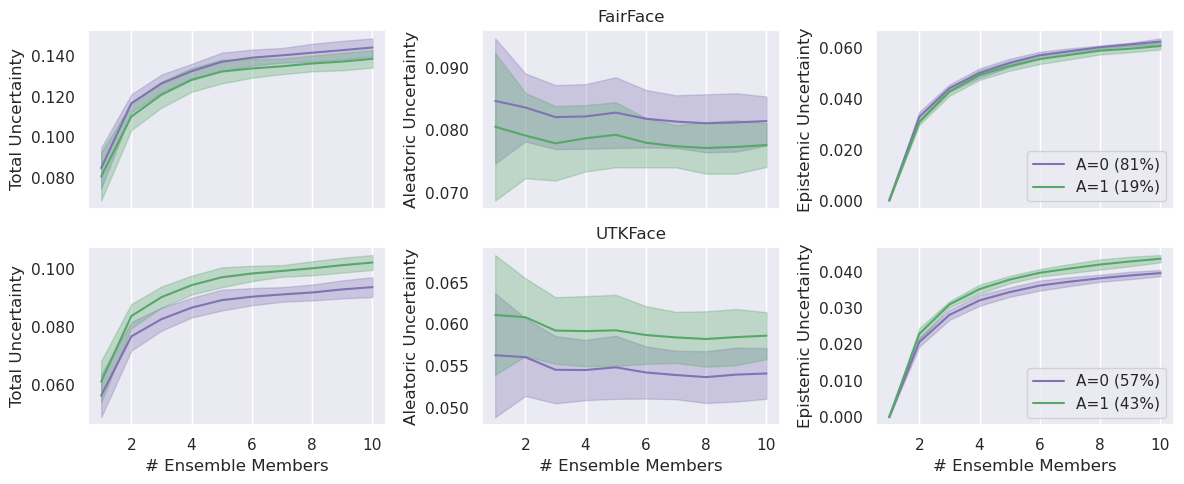

In [107]:
ensemble_members = list(range(1, len(ff_test_probits[0]) + 1))
eps = 1e-10

f, axs = plt.subplots(2, 3, figsize=(12, 5), sharex=True)
    
ff_test_m_total_a1, ff_test_m_total_a0 = list(), list()
ff_test_m_ale_a1, ff_test_m_ale_a0 = list(), list()
ff_test_m_epi_a1, ff_test_m_epi_a0 = list(), list()
utk_test_m_total_a1, utk_test_m_total_a0 = list(), list()
utk_test_m_ale_a1, utk_test_m_ale_a0 = list(), list()
utk_test_m_epi_a1, utk_test_m_epi_a0 = list(), list()

for em in ensemble_members:
    probits = torch.stack(ff_test_probits)
    S, M, N, P = probits.shape
    preds = probits[:, :em]
    ale = - torch.mean(torch.sum(preds * torch.log(preds + eps), dim=3), dim=1)
    preds = torch.mean(preds, dim=1)
    total = - torch.sum(preds * torch.log(preds + eps), dim=2)

    ff_test_m_total_a1.append(total[:, a_ff_test_t == 1].mean(dim=1))
    ff_test_m_total_a0.append(total[:, a_ff_test_t == 0].mean(dim=1))
    ff_test_m_ale_a1.append(ale[:, a_ff_test_t == 1].mean(dim=1))
    ff_test_m_ale_a0.append(ale[:, a_ff_test_t == 0].mean(dim=1))
    ff_test_m_epi_a1.append((total[:, a_ff_test_t == 1] - ale[:, a_ff_test_t == 1]).mean(dim=1))
    ff_test_m_epi_a0.append((total[:, a_ff_test_t == 0] - ale[:, a_ff_test_t == 0]).mean(dim=1))

    probits = torch.stack(utk_test_probits)
    preds = probits[:, :em]
    ale = - torch.mean(torch.sum(preds * torch.log(preds + eps), dim=3), dim=1)
    preds = torch.mean(preds, dim=1)
    total = - torch.sum(preds * torch.log(preds + eps), dim=2)

    utk_test_m_total_a1.append(total[:, a_utk_test_t == 1].mean(dim=1))
    utk_test_m_total_a0.append(total[:, a_utk_test_t == 0].mean(dim=1))
    utk_test_m_ale_a1.append(ale[:, a_utk_test_t == 1].mean(dim=1))
    utk_test_m_ale_a0.append(ale[:, a_utk_test_t == 0].mean(dim=1))
    utk_test_m_epi_a1.append((total[:, a_utk_test_t == 1] - ale[:, a_utk_test_t == 1]).mean(dim=1))
    utk_test_m_epi_a0.append((total[:, a_utk_test_t == 0] - ale[:, a_utk_test_t == 0]).mean(dim=1))

ff_test_m_total_a1 = torch.stack(ff_test_m_total_a1)
ff_test_m_total_a0 = torch.stack(ff_test_m_total_a0)
ff_test_m_ale_a1 = torch.stack(ff_test_m_ale_a1)
ff_test_m_ale_a0 = torch.stack(ff_test_m_ale_a0)
ff_test_m_epi_a1 = torch.stack(ff_test_m_epi_a1)
ff_test_m_epi_a0 = torch.stack(ff_test_m_epi_a0)
utk_test_m_total_a1 = torch.stack(utk_test_m_total_a1)
utk_test_m_total_a0 = torch.stack(utk_test_m_total_a0)
utk_test_m_ale_a1 = torch.stack(utk_test_m_ale_a1)
utk_test_m_ale_a0 = torch.stack(utk_test_m_ale_a0)
utk_test_m_epi_a1 = torch.stack(utk_test_m_epi_a1)
utk_test_m_epi_a0 = torch.stack(utk_test_m_epi_a0)

for t, test_ent in enumerate([ff_test_m_total_a0, ff_test_m_total_a1]):
    axs[0, 0].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)")
    axs[0, 0].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
    axs[0, 0].set_ylabel("Total Uncertainty")
for t, test_ent in enumerate([ff_test_m_ale_a0, ff_test_m_ale_a1]):
    axs[0, 1].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)")
    axs[0, 1].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
    axs[0, 1].set_ylabel("Aleatoric Uncertainty")
for t, test_ent in enumerate([ff_test_m_epi_a0, ff_test_m_epi_a1]):
    axs[0, 2].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)")
    axs[0, 2].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
    axs[0, 2].set_ylabel("Epistemic Uncertainty")
    axs[0, 2].legend(loc="lower right")
for t, test_ent in enumerate([utk_test_m_total_a0, utk_test_m_total_a1]):
    axs[1, 0].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_utk_test if t == 1 else 100 - p_a_utk_test):.0f}%)")
    axs[1, 0].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
    axs[1, 0].set_ylabel("Total Uncertainty")
for t, test_ent in enumerate([utk_test_m_ale_a0, utk_test_m_ale_a1]):
    axs[1, 1].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_utk_test if t == 1 else 100 - p_a_utk_test):.0f}%)")
    axs[1, 1].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
    axs[1, 1].set_ylabel("Aleatoric Uncertainty")
for t, test_ent in enumerate([utk_test_m_epi_a0, utk_test_m_epi_a1]):
    axs[1, 2].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"A={t} ({(p_a_utk_test if t == 1 else 100 - p_a_utk_test):.0f}%)")
    axs[1, 2].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
    axs[1, 2].set_ylabel("Epistemic Uncertainty")
    axs[1, 2].legend(loc="lower right")

axs[0, 1].set_title("FairFace")
axs[1, 1].set_title("UTKFace")

for i, ax in enumerate(axs.flatten()):
    ax.yaxis.grid(False)
    if i >= 3:
        ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_uncertainty_a.pdf"))
plt.show()

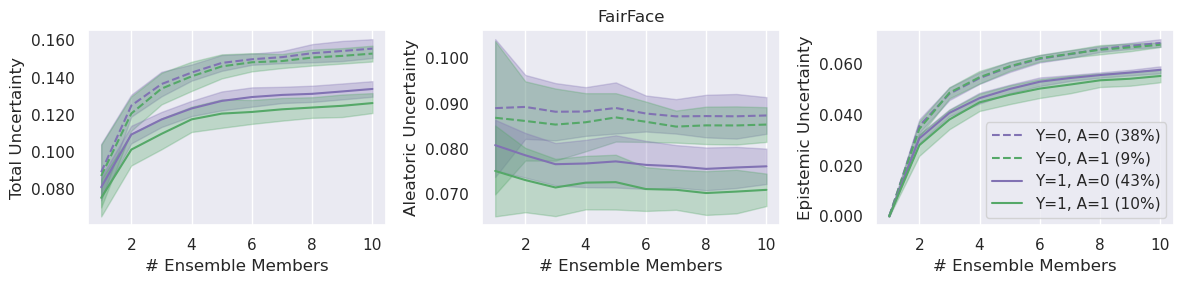

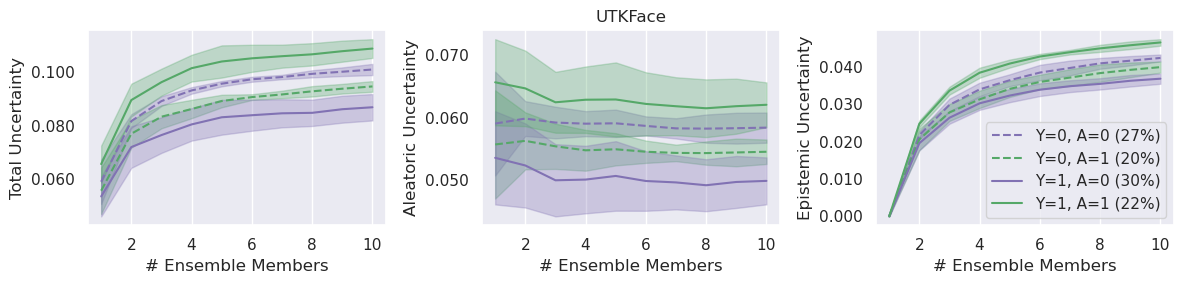

In [108]:
ensemble_members = list(range(1, len(ff_test_probits[0]) + 1))
eps = 1e-10
    
ff_test_m_total_y0_a0, ff_test_m_total_y1_a0, ff_test_m_total_y0_a1, ff_test_m_total_y1_a1 = list(), list(), list(), list()
ff_test_m_ale_y0_a0, ff_test_m_ale_y1_a0, ff_test_m_ale_y0_a1, ff_test_m_ale_y1_a1 = list(), list(), list(), list()
ff_test_m_epi_y0_a0, ff_test_m_epi_y1_a0, ff_test_m_epi_y0_a1, ff_test_m_epi_y1_a1 = list(), list(), list(), list()
utk_test_m_total_y0_a0, utk_test_m_total_y1_a0, utk_test_m_total_y0_a1, utk_test_m_total_y1_a1 = list(), list(), list(), list()
utk_test_m_ale_y0_a0, utk_test_m_ale_y1_a0, utk_test_m_ale_y0_a1, utk_test_m_ale_y1_a1 = list(), list(), list(), list()
utk_test_m_epi_y0_a0, utk_test_m_epi_y1_a0, utk_test_m_epi_y0_a1, utk_test_m_epi_y1_a1 = list(), list(), list(), list()

for em in ensemble_members:
    probits = torch.stack(ff_test_probits)
    S, M, N, P = probits.shape
    preds = probits[:, :em]
    ale = - torch.mean(torch.sum(preds * torch.log(preds + eps), dim=3), dim=1)
    preds = torch.mean(preds, dim=1)
    total = - torch.sum(preds * torch.log(preds + eps), dim=2)
    
    ff_test_m_total_y0_a0.append(total[:, (y_ff_test_t == 0) & (a_ff_test_t == 0)].mean(dim=1))
    ff_test_m_total_y1_a0.append(total[:, (y_ff_test_t == 1) & (a_ff_test_t == 0)].mean(dim=1))
    ff_test_m_total_y0_a1.append(total[:, (y_ff_test_t == 0) & (a_ff_test_t == 1)].mean(dim=1))
    ff_test_m_total_y1_a1.append(total[:, (y_ff_test_t == 1) & (a_ff_test_t == 1)].mean(dim=1))
    ff_test_m_ale_y0_a0.append(ale[:, (y_ff_test_t == 0) & (a_ff_test_t == 0)].mean(dim=1))
    ff_test_m_ale_y1_a0.append(ale[:, (y_ff_test_t == 1) & (a_ff_test_t == 0)].mean(dim=1))
    ff_test_m_ale_y0_a1.append(ale[:, (y_ff_test_t == 0) & (a_ff_test_t == 1)].mean(dim=1))
    ff_test_m_ale_y1_a1.append(ale[:, (y_ff_test_t == 1) & (a_ff_test_t == 1)].mean(dim=1))
    ff_test_m_epi_y0_a0.append((total[:, (y_ff_test_t == 0) & (a_ff_test_t == 0)] - ale[:, (y_ff_test_t == 0) & (a_ff_test_t == 0)]).mean(dim=1))
    ff_test_m_epi_y1_a0.append((total[:, (y_ff_test_t == 1) & (a_ff_test_t == 0)] - ale[:, (y_ff_test_t == 1) & (a_ff_test_t == 0)]).mean(dim=1))
    ff_test_m_epi_y0_a1.append((total[:, (y_ff_test_t == 0) & (a_ff_test_t == 1)] - ale[:, (y_ff_test_t == 0) & (a_ff_test_t == 1)]).mean(dim=1))
    ff_test_m_epi_y1_a1.append((total[:, (y_ff_test_t == 1) & (a_ff_test_t == 1)] - ale[:, (y_ff_test_t == 1) & (a_ff_test_t == 1)]).mean(dim=1))

    probits = torch.stack(utk_test_probits)
    preds = probits[:, :em]
    ale = - torch.mean(torch.sum(preds * torch.log(preds + eps), dim=3), dim=1)
    preds = torch.mean(preds, dim=1)
    total = - torch.sum(preds * torch.log(preds + eps), dim=2)

    utk_test_m_total_y0_a0.append(total[:, (y_utk_test_t == 0) & (a_utk_test_t == 0)].mean(dim=1))
    utk_test_m_total_y1_a0.append(total[:, (y_utk_test_t == 1) & (a_utk_test_t == 0)].mean(dim=1))
    utk_test_m_total_y0_a1.append(total[:, (y_utk_test_t == 0) & (a_utk_test_t == 1)].mean(dim=1))
    utk_test_m_total_y1_a1.append(total[:, (y_utk_test_t == 1) & (a_utk_test_t == 1)].mean(dim=1))
    utk_test_m_ale_y0_a0.append(ale[:, (y_utk_test_t == 0) & (a_utk_test_t == 0)].mean(dim=1))
    utk_test_m_ale_y1_a0.append(ale[:, (y_utk_test_t == 1) & (a_utk_test_t == 0)].mean(dim=1))
    utk_test_m_ale_y0_a1.append(ale[:, (y_utk_test_t == 0) & (a_utk_test_t == 1)].mean(dim=1))
    utk_test_m_ale_y1_a1.append(ale[:, (y_utk_test_t == 1) & (a_utk_test_t == 1)].mean(dim=1))
    utk_test_m_epi_y0_a0.append((total[:, (y_utk_test_t == 0) & (a_utk_test_t == 0)] - ale[:, (y_utk_test_t == 0) & (a_utk_test_t == 0)]).mean(dim=1))
    utk_test_m_epi_y1_a0.append((total[:, (y_utk_test_t == 1) & (a_utk_test_t == 0)] - ale[:, (y_utk_test_t == 1) & (a_utk_test_t == 0)]).mean(dim=1))
    utk_test_m_epi_y0_a1.append((total[:, (y_utk_test_t == 0) & (a_utk_test_t == 1)] - ale[:, (y_utk_test_t == 0) & (a_utk_test_t == 1)]).mean(dim=1))
    utk_test_m_epi_y1_a1.append((total[:, (y_utk_test_t == 1) & (a_utk_test_t == 1)] - ale[:, (y_utk_test_t == 1) & (a_utk_test_t == 1)]).mean(dim=1))

ff_test_m_total_y0_a0 = torch.stack(ff_test_m_total_y0_a0)
ff_test_m_total_y1_a0 = torch.stack(ff_test_m_total_y1_a0)
ff_test_m_total_y0_a1 = torch.stack(ff_test_m_total_y0_a1)
ff_test_m_total_y1_a1 = torch.stack(ff_test_m_total_y1_a1)
ff_test_m_ale_y0_a0 = torch.stack(ff_test_m_ale_y0_a0)
ff_test_m_ale_y1_a0 = torch.stack(ff_test_m_ale_y1_a0)
ff_test_m_ale_y0_a1 = torch.stack(ff_test_m_ale_y0_a1)
ff_test_m_ale_y1_a1 = torch.stack(ff_test_m_ale_y1_a1)
ff_test_m_epi_y0_a0 = torch.stack(ff_test_m_epi_y0_a0)
ff_test_m_epi_y1_a0 = torch.stack(ff_test_m_epi_y1_a0)
ff_test_m_epi_y0_a1 = torch.stack(ff_test_m_epi_y0_a1)
ff_test_m_epi_y1_a1 = torch.stack(ff_test_m_epi_y1_a1)
utk_test_m_total_y0_a0 = torch.stack(utk_test_m_total_y0_a0)   
utk_test_m_total_y1_a0 = torch.stack(utk_test_m_total_y1_a0)
utk_test_m_total_y0_a1 = torch.stack(utk_test_m_total_y0_a1)
utk_test_m_total_y1_a1 = torch.stack(utk_test_m_total_y1_a1)
utk_test_m_ale_y0_a0 = torch.stack(utk_test_m_ale_y0_a0)
utk_test_m_ale_y1_a0 = torch.stack(utk_test_m_ale_y1_a0)
utk_test_m_ale_y0_a1 = torch.stack(utk_test_m_ale_y0_a1)
utk_test_m_ale_y1_a1 = torch.stack(utk_test_m_ale_y1_a1)
utk_test_m_epi_y0_a0 = torch.stack(utk_test_m_epi_y0_a0)
utk_test_m_epi_y1_a0 = torch.stack(utk_test_m_epi_y1_a0)
utk_test_m_epi_y0_a1 = torch.stack(utk_test_m_epi_y0_a1)
utk_test_m_epi_y1_a1 = torch.stack(utk_test_m_epi_y1_a1)


f, axs = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
for t, test_ent in enumerate([ff_test_m_total_y0_a0, ff_test_m_total_y0_a1]):
    axs[0].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_ff_test) * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
    axs[0].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([ff_test_m_total_y1_a0, ff_test_m_total_y1_a1]):
    axs[0].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({((p_y_ff_test) * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
    axs[0].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[0].set_ylabel("Total Uncertainty")
for t, test_ent in enumerate([ff_test_m_ale_y0_a0, ff_test_m_ale_y0_a1]):
    axs[1].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_ff_test) * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
    axs[1].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([ff_test_m_ale_y1_a0, ff_test_m_ale_y1_a1]):
    axs[1].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({((p_y_ff_test) * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
    axs[1].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[1].set_ylabel("Aleatoric Uncertainty")
for t, test_ent in enumerate([ff_test_m_epi_y0_a0, ff_test_m_epi_y0_a1]):
    axs[2].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_ff_test) * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
    axs[2].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([ff_test_m_epi_y1_a0, ff_test_m_epi_y1_a1]):
    axs[2].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({((p_y_ff_test) * (p_a_ff_test if t == 1 else 100 - p_a_ff_test) / 100):.0f}%)")
    axs[2].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[2].set_ylabel("Epistemic Uncertainty")
axs[2].legend(loc="lower right")

axs[1].set_title("FairFace")

for i, ax in enumerate(axs.flatten()):
    ax.yaxis.grid(False)
    ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_uncertainty_ya_ff.pdf"))
plt.show()



f, axs = plt.subplots(1, 3, figsize=(12, 3), sharex=True)

for t, test_ent in enumerate([utk_test_m_total_y0_a0, utk_test_m_total_y0_a1]):
    axs[0].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_utk_test) * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
    axs[0].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([utk_test_m_total_y1_a0, utk_test_m_total_y1_a1]):
    axs[0].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({((p_y_utk_test) * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
    axs[0].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[0].set_ylabel("Total Uncertainty")
for t, test_ent in enumerate([utk_test_m_ale_y0_a0, utk_test_m_ale_y0_a1]):
    axs[1].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_utk_test) * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
    axs[1].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([utk_test_m_ale_y1_a0, utk_test_m_ale_y1_a1]):
    axs[1].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({((p_y_utk_test) * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
    axs[1].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[1].set_ylabel("Aleatoric Uncertainty")
for t, test_ent in enumerate([utk_test_m_epi_y0_a0, utk_test_m_epi_y0_a1]):
    axs[2].plot(ensemble_members, torch.mean(test_ent, dim=1), "--", color=["C4", "C2"][t], 
                    label=f"Y=0, A={t} ({((100 - p_y_utk_test) * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
    axs[2].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
for t, test_ent in enumerate([utk_test_m_epi_y1_a0, utk_test_m_epi_y1_a1]):
    axs[2].plot(ensemble_members, torch.mean(test_ent, dim=1), "-", color=["C4", "C2"][t], 
                    label=f"Y=1, A={t} ({((p_y_utk_test) * (p_a_utk_test if t == 1 else 100 - p_a_utk_test) / 100):.0f}%)")
    axs[2].fill_between(ensemble_members,
                        torch.mean(test_ent, dim=1) - torch.std(test_ent, dim=1), 
                        torch.mean(test_ent, dim=1) + torch.std(test_ent, dim=1), color=["C4", "C2"][t], alpha=0.3)
axs[2].set_ylabel("Epistemic Uncertainty")
axs[2].legend(loc="lower right")

axs[1].set_title("UTKFace")

for i, ax in enumerate(axs.flatten()):
    ax.yaxis.grid(False)
    ax.set_xlabel("# Ensemble Members")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}"))

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_uncertainty_ya_utk.pdf"))
plt.show()

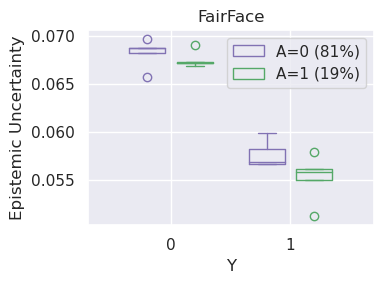

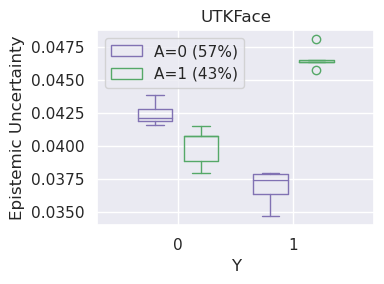

In [109]:
plt.figure(figsize=(4, 3))

bps = list()
for t, test_ent in enumerate([ff_test_m_epi_y0_a0, ff_test_m_epi_y0_a1]):
    bps.append(plt.boxplot(test_ent[-1], positions=[t / 5 * 2 - 0.2], widths=0.3, 
                boxprops=dict(color=["C4", "C2"][t]), flierprops=dict(markeredgecolor=["C4", "C2"][t])))
for t, test_ent in enumerate([ff_test_m_epi_y1_a0, ff_test_m_epi_y1_a1]):
    bps.append(plt.boxplot(test_ent[-1], positions=[t / 5 * 2 + 0.8], widths=0.3, 
                boxprops=dict(color=["C4", "C2"][t]), flierprops=dict(markeredgecolor=["C4", "C2"][t])))
plt.title("FairFace")
plt.ylabel("Epistemic Uncertainty")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
for b, boxplot in enumerate(bps):
    # Set the color of the whiskers, caps, and medians to match the box color
    plt.setp(boxplot['whiskers'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['caps'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['medians'], color=["C4", "C2"][b%2])
plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_ff_test if t == 1 else 100 - p_a_ff_test):.0f}%)") for t in range(2)])
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_epi_ya_ff.pdf"))
plt.show()


plt.figure(figsize=(4, 3))

bps = list()
for t, test_ent in enumerate([utk_test_m_epi_y0_a0, utk_test_m_epi_y0_a1]):
    bps.append(plt.boxplot(test_ent[-1], positions=[t / 5 * 2 - 0.2], widths=0.3, 
                boxprops=dict(color=["C4", "C2"][t]), flierprops=dict(markeredgecolor=["C4", "C2"][t])))
for t, test_ent in enumerate([utk_test_m_epi_y1_a0, utk_test_m_epi_y1_a1]):
    bps.append(plt.boxplot(test_ent[-1], positions=[t / 5 * 2 + 0.8], widths=0.3, 
                boxprops=dict(color=["C4", "C2"][t]), flierprops=dict(markeredgecolor=["C4", "C2"][t])))
plt.title("UTKFace")
plt.ylabel("Epistemic Uncertainty")
plt.xlabel("Y")
plt.xticks([0, 1], ["0", "1"])
for b, boxplot in enumerate(bps):
    # Set the color of the whiskers, caps, and medians to match the box color
    plt.setp(boxplot['whiskers'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['caps'], color=["C4", "C2"][b%2])
    plt.setp(boxplot['medians'], color=["C4", "C2"][b%2])
plt.legend(handles=[patches.Patch(edgecolor=["C4", "C2"][t], facecolor="none", label=f"A={t} ({(p_a_utk_test if t == 1 else 100 - p_a_utk_test):.0f}%)") for t in range(2)])
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_epi_ya_utk.pdf"))
plt.show()

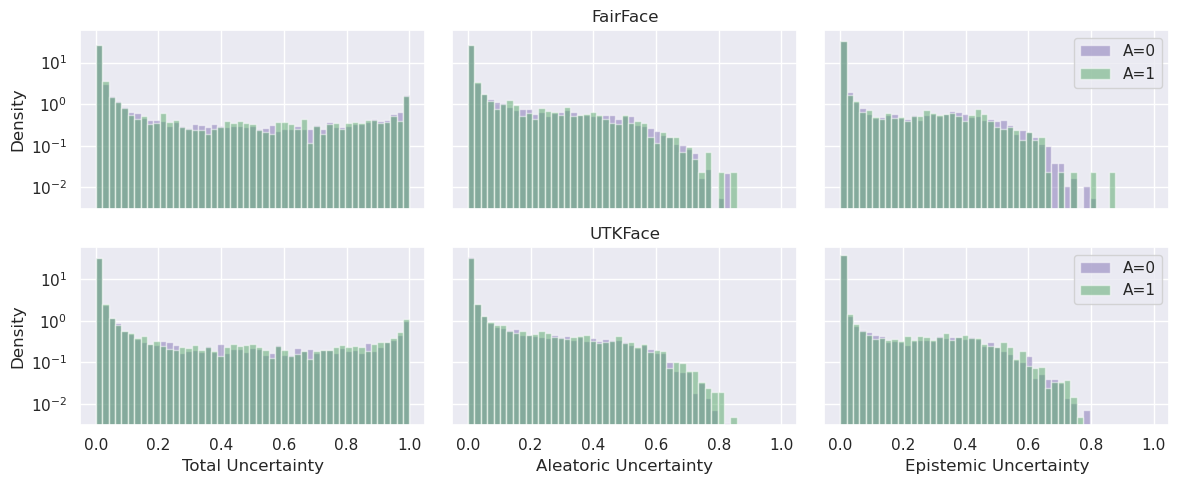

In [110]:
use_density=True
bins = np.linspace(0, 1, 50)
eps = 1e-10

f, axs = plt.subplots(2, 3, figsize=(12, 5), sharex=True, sharey=True)
    
for u, uncertainty in enumerate(["Total", "Aleatoric", "Epistemic"]):

    preds = torch.stack(ff_test_probits)
    S, M, N, P = preds.shape
    ale = - torch.mean(torch.sum(preds * torch.log(preds + eps), dim=3), dim=1) / np.log(2)
    preds = torch.mean(preds, dim=1)
    total = - torch.sum(preds * torch.log(preds + eps), dim=2) / np.log(2)

    if uncertainty == "Total":
        ff_test_m_unc_1 = total[:, a_ff_test_t == 1]
        ff_test_m_unc_0 = total[:, a_ff_test_t == 0]
    elif uncertainty == "Aleatoric":
        ff_test_m_unc_1 = ale[:, a_ff_test_t == 1]
        ff_test_m_unc_0 = ale[:, a_ff_test_t == 0]
    elif uncertainty == "Epistemic":
        ff_test_m_unc_1 = total[:, a_ff_test_t == 1] - ale[:, a_ff_test_t == 1]
        ff_test_m_unc_0 =  total[:, a_ff_test_t == 0] - ale[:, a_ff_test_t == 0]

    preds = torch.stack(utk_test_probits)
    ale = - torch.mean(torch.sum(preds * torch.log(preds + eps), dim=3), dim=1) / np.log(2)
    preds = torch.mean(preds, dim=1)
    total = - torch.sum(preds * torch.log(preds + eps), dim=2) / np.log(2)

    if uncertainty == "Total":
        utk_test_m_unc_1 = total[:, a_utk_test_t == 1]
        utk_test_m_unc_0 = total[:, a_utk_test_t == 0]
    elif uncertainty == "Aleatoric":
        utk_test_m_unc_1 = ale[:, a_utk_test_t == 1]
        utk_test_m_unc_0 = ale[:, a_utk_test_t == 0]
    elif uncertainty == "Epistemic":
        utk_test_m_unc_1 = (total[:, a_utk_test_t == 1] - ale[:, a_utk_test_t == 1])
        utk_test_m_unc_0 = (total[:, a_utk_test_t == 0] - ale[:, a_utk_test_t == 0])

    axs[0, u].hist(ff_test_m_unc_0[0], bins, alpha=0.5, label="A=0", density=use_density, color=["C4", "C2"][0])
    axs[0, u].hist(ff_test_m_unc_1[0], bins, alpha=0.5, label="A=1", density=use_density, color=["C4", "C2"][1])
    axs[0, u].set_yscale("log")

    axs[1, u].hist(utk_test_m_unc_0[0], bins, alpha=0.5, label="A=0", density=use_density, color=["C4", "C2"][0])
    axs[1, u].hist(utk_test_m_unc_1[0], bins, alpha=0.5, label="A=1", density=use_density, color=["C4", "C2"][1])
    axs[1, u].set_yscale("log")

axs[1, 0].set_xlabel("Total Uncertainty")
axs[1, 1].set_xlabel("Aleatoric Uncertainty")
axs[1, 2].set_xlabel("Epistemic Uncertainty")

axs[0, 1].set_title("FairFace")
axs[1, 1].set_title("UTKFace")

axs[0, 0].set_ylabel("Density" if use_density else "Count") 
axs[1, 0].set_ylabel("Density" if use_density else "Count") 

axs[0, 2].legend(loc="upper right")
axs[1, 2].legend(loc="upper right")

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_uncertainty_compact.pdf"))
plt.show()

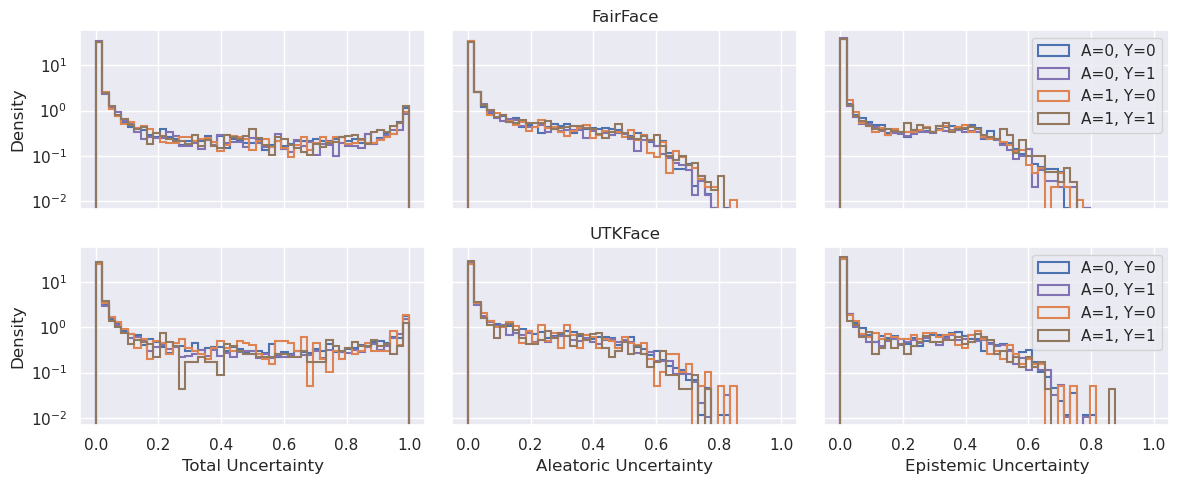

In [111]:
use_density=True
bins = np.linspace(0, 1, 50)
eps = 1e-10

f, axs = plt.subplots(2, 3, figsize=(12, 5), sharex=True, sharey=True)
    
for u, uncertainty in enumerate(["Total", "Aleatoric", "Epistemic"]):

    preds = torch.stack(ff_test_probits)
    S, M, N, P = preds.shape
    ale = - torch.mean(torch.sum(preds * torch.log(preds + eps), dim=3), dim=1) / np.log(2)
    preds = torch.mean(preds, dim=1)
    total = - torch.sum(preds * torch.log(preds + eps), dim=2) / np.log(2)

    if uncertainty == "Total":
        ff_test_m_unc_1_1 = total[:, (a_ff_test_t == 1) & (y_ff_test_t == 1)]
        ff_test_m_unc_1_0 = total[:, (a_ff_test_t == 1) & (y_ff_test_t == 0)]
        ff_test_m_unc_0_1 = total[:, (a_ff_test_t == 0) & (y_ff_test_t == 1)]
        ff_test_m_unc_0_0 = total[:, (a_ff_test_t == 0) & (y_ff_test_t == 0)]
    elif uncertainty == "Aleatoric":
        ff_test_m_unc_1_1 = ale[:, (a_ff_test_t == 1) & (y_ff_test_t == 1)]
        ff_test_m_unc_1_0 = ale[:, (a_ff_test_t == 1) & (y_ff_test_t == 0)]
        ff_test_m_unc_0_1 = ale[:, (a_ff_test_t == 0) & (y_ff_test_t == 1)]
        ff_test_m_unc_0_0 = ale[:, (a_ff_test_t == 0) & (y_ff_test_t == 0)]
    elif uncertainty == "Epistemic":
        ff_test_m_unc_1_1 = (total[:, (a_ff_test_t == 1) & (y_ff_test_t == 1)] - ale[:, (a_ff_test_t == 1) & (y_ff_test_t == 1)])
        ff_test_m_unc_1_0 = (total[:, (a_ff_test_t == 1) & (y_ff_test_t == 0)] - ale[:, (a_ff_test_t == 1) & (y_ff_test_t == 0)])
        ff_test_m_unc_0_1 = (total[:, (a_ff_test_t == 0) & (y_ff_test_t == 1)] - ale[:, (a_ff_test_t == 0) & (y_ff_test_t == 1)])
        ff_test_m_unc_0_0 = (total[:, (a_ff_test_t == 0) & (y_ff_test_t == 0)] - ale[:, (a_ff_test_t == 0) & (y_ff_test_t == 0)])

    preds = torch.stack(utk_test_probits)
    ale = - torch.mean(torch.sum(preds * torch.log(preds + eps), dim=3), dim=1) / np.log(2)
    preds = torch.mean(preds, dim=1)
    total = - torch.sum(preds * torch.log(preds + eps), dim=2) / np.log(2)

    if uncertainty == "Total":
        utk_test_m_unc_1_1 = total[:, (a_utk_test_t == 1) & (y_utk_test_t == 1)]
        utk_test_m_unc_1_0 = total[:, (a_utk_test_t == 1) & (y_utk_test_t == 0)]
        utk_test_m_unc_0_1 = total[:, (a_utk_test_t == 0) & (y_utk_test_t == 1)]
        utk_test_m_unc_0_0 = total[:, (a_utk_test_t == 0) & (y_utk_test_t == 0)]
    elif uncertainty == "Aleatoric":
        utk_test_m_unc_1_1 = ale[:, (a_utk_test_t == 1) & (y_utk_test_t == 1)]
        utk_test_m_unc_1_0 = ale[:, (a_utk_test_t == 1) & (y_utk_test_t == 0)]
        utk_test_m_unc_0_1 = ale[:, (a_utk_test_t == 0) & (y_utk_test_t == 1)]
        utk_test_m_unc_0_0 = ale[:, (a_utk_test_t == 0) & (y_utk_test_t == 0)]
    elif uncertainty == "Epistemic":
        utk_test_m_unc_1_1 = (total[:, (a_utk_test_t == 1) & (y_utk_test_t == 1)] - ale[:, (a_utk_test_t == 1) & (y_utk_test_t == 1)])
        utk_test_m_unc_1_0 = (total[:, (a_utk_test_t == 1) & (y_utk_test_t == 0)] - ale[:, (a_utk_test_t == 1) & (y_utk_test_t == 0)])
        utk_test_m_unc_0_1 = (total[:, (a_utk_test_t == 0) & (y_utk_test_t == 1)] - ale[:, (a_utk_test_t == 0) & (y_utk_test_t == 1)])
        utk_test_m_unc_0_0 = (total[:, (a_utk_test_t == 0) & (y_utk_test_t == 0)] - ale[:, (a_utk_test_t == 0) & (y_utk_test_t == 0)])

    axs[0, u].hist(utk_test_m_unc_0_0[0], bins, label="A=0, Y=0", color="C0", lw=1.5, histtype="step", density=use_density)
    axs[0, u].hist(utk_test_m_unc_0_1[0], bins, label="A=0, Y=1", color="C4", lw=1.5, histtype="step", density=use_density)
    axs[0, u].hist(utk_test_m_unc_1_0[0], bins, label="A=1, Y=0", color="C1", lw=1.5, histtype="step", density=use_density)
    axs[0, u].hist(utk_test_m_unc_1_1[0], bins, label="A=1, Y=1", color="C5", lw=1.5, histtype="step", density=use_density)
    axs[0, u].set_yscale("log")

    axs[1, u].hist(ff_test_m_unc_0_0[0], bins, label="A=0, Y=0", color="C0", lw=1.5, histtype="step", density=use_density)
    axs[1, u].hist(ff_test_m_unc_0_1[0], bins, label="A=0, Y=1", color="C4", lw=1.5, histtype="step", density=use_density)
    axs[1, u].hist(ff_test_m_unc_1_0[0], bins, label="A=1, Y=0", color="C1", lw=1.5, histtype="step", density=use_density)
    axs[1, u].hist(ff_test_m_unc_1_1[0], bins, label="A=1, Y=1", color="C5", lw=1.5, histtype="step", density=use_density)
    axs[1, u].set_yscale("log")

axs[1, 0].set_xlabel("Total Uncertainty")
axs[1, 1].set_xlabel("Aleatoric Uncertainty")
axs[1, 2].set_xlabel("Epistemic Uncertainty")

axs[0, 1].set_title("FairFace")
axs[1, 1].set_title("UTKFace")

axs[0, 0].set_ylabel("Density" if use_density else "Count") 
axs[1, 0].set_ylabel("Density" if use_density else "Count") 

axs[0, 2].legend(loc="upper right")
axs[1, 2].legend(loc="upper right")

f.tight_layout()
plt.savefig(os.path.join(PLOTS_PATH, f"n_members_target{target}_pa{pa}_{model}_uncertainty_pery_compact.pdf"))
plt.show()

In [112]:
print("#" * 80)
print(f"FairFace Test Set | Target: {targets[target]} | Protected Attribute: {targets[pa]}")
print("#" * 80)

# Individual models
# only first model per seed
print("Individual Models:")
print(f"Accuracy: Mean = {np.mean(np.asarray(ff_test_accs)[:, 0] * 100):.2f}, Std = {np.std(np.asarray(ff_test_accs)[:, 0] * 100):.2f}")
print(f"SPD: Mean = {np.mean(np.asarray(ff_test_spds)[:, 0]):.4f}, Std = {np.std(np.asarray(ff_test_spds)[:, 0]):.4f}")
print(f"EOD: Mean = {np.mean(np.asarray(ff_test_eods)[:, 0]):.4f}, Std = {np.std(np.asarray(ff_test_eods)[:, 0]):.4f}")
print(f"AOD: Mean = {np.mean(np.asarray(ff_test_aods)[:, 0]):.4f}, Std = {np.std(np.asarray(ff_test_aods)[:, 0]):.4f}")
print("-" * 80)

# all models over all seeds
print("Individual Models (all):")
print(f"Accuracy: Mean = {np.mean(np.asarray(ff_test_accs) * 100):.2f}, Std = {np.std(np.asarray(ff_test_accs) * 100):.2f}")
print(f"SPD: Mean = {np.mean(ff_test_spds):.4f}, Std = {np.std(ff_test_spds):.4f}")
print(f"EOD: Mean = {np.mean(ff_test_eods):.4f}, Std = {np.std(ff_test_eods):.4f}")
print(f"AOD: Mean = {np.mean(ff_test_aods):.4f}, Std = {np.std(ff_test_aods):.4f}")
print("-" * 80)

# Fairest model on Fairness dataset
print("Fairest Model (on Fairness Dataset):")
fairest_acc_spd = np.asarray(ff_test_accs)[:, np.argmin(np.asarray(fair_spds), axis=1)]
print(f"Accuracy (SPD): Mean = {np.mean(fairest_acc_spd * 100):.2f}, Std = {np.std(fairest_acc_spd * 100):.2f}")
fairest_spds = np.asarray(ff_test_spds)[:, np.argmin(np.asarray(fair_spds), axis=1)]
print(f"SPD: Mean = {np.mean(fairest_spds):.4f}, Std = {np.std(fairest_spds):.4f}")
fairest_acc_eod = np.asarray(ff_test_accs)[:, np.argmin(np.asarray(fair_eods), axis=1)]
print(f"Accuracy (EOD): Mean = {np.mean(fairest_acc_eod * 100):.2f}, Std = {np.std(fairest_acc_eod * 100):.2f}")
fairest_eods = np.asarray(ff_test_eods)[:, np.argmin(np.asarray(fair_eods), axis=1)]
print(f"EOD: Mean = {np.mean(fairest_eods):.4f}, Std = {np.std(fairest_eods):.4f}")
fairest_acc_aod = np.asarray(ff_test_accs)[:, np.argmin(np.asarray(fair_aods), axis=1)]
print(f"Accuracy (AOD): Mean = {np.mean(fairest_acc_aod * 100):.2f}, Std = {np.std(fairest_acc_aod * 100):.2f}")
fairest_aods = np.asarray(ff_test_aods)[:, np.argmin(np.asarray(fair_aods), axis=1)]
print(f"AOD: Mean = {np.mean(fairest_aods):.4f}, Std = {np.std(fairest_aods):.4f}")
print("-" * 80)

# Fairest model on Validation dataset
print("Fairest Model (on Validation Dataset):")
fairest_acc_spd = np.asarray(ff_test_accs)[:, np.argmin(np.asarray(val_spds), axis=1)]
print(f"Accuracy (SPD): Mean = {np.mean(fairest_acc_spd * 100):.2f}, Std = {np.std(fairest_acc_spd * 100):.2f}")
fairest_spds = np.asarray(ff_test_spds)[:, np.argmin(np.asarray(val_spds), axis=1)]
print(f"SPD: Mean = {np.mean(fairest_spds):.4f}, Std = {np.std(fairest_spds):.4f}")
fairest_acc_eod = np.asarray(ff_test_accs)[:, np.argmin(np.asarray(val_eods), axis=1)]
print(f"Accuracy (EOD): Mean = {np.mean(fairest_acc_eod * 100):.2f}, Std = {np.std(fairest_acc_eod * 100):.2f}")
fairest_eods = np.asarray(ff_test_eods)[:, np.argmin(np.asarray(val_eods), axis=1)]
print(f"EOD: Mean = {np.mean(fairest_eods):.4f}, Std = {np.std(fairest_eods):.4f}")
fairest_acc_aod = np.asarray(ff_test_accs)[:, np.argmin(np.asarray(val_aods), axis=1)]
print(f"Accuracy (AOD): Mean = {np.mean(fairest_acc_aod * 100):.2f}, Std = {np.std(fairest_acc_aod * 100):.2f}")
fairest_aods = np.asarray(ff_test_aods)[:, np.argmin(np.asarray(val_aods), axis=1)]
print(f"AOD: Mean = {np.mean(fairest_aods):.4f}, Std = {np.std(fairest_aods):.4f}")
print("-" * 80)

# BMA
print("Uniform Average:")
print(f"Accuracy: Mean = {np.mean(np.asarray(ff_test_m_accs) * 100):.2f}, Std = {np.std(np.asarray(ff_test_m_accs) * 100):.2f}")
print(f"SPD: Mean = {np.mean(ff_test_m_spds):.4f}, Std = {np.std(ff_test_m_spds):.4f}")
print(f"EOD: Mean = {np.mean(ff_test_m_eods):.4f}, Std = {np.std(ff_test_m_eods):.4f}")
print(f"AOD: Mean = {np.mean(ff_test_m_aods):.4f}, Std = {np.std(ff_test_m_aods):.4f}")
print("-" * 80)

# Tempered average
print("Fairness Weighted Average:")
print(f"Accuracy (SPD): Mean = {np.mean(np.asarray(ff_test_fm_spd_accs) * 100):.2f}, Std = {np.std(np.asarray(ff_test_fm_spd_accs) * 100):.2f}")
print(f"SPD: Mean = {np.mean(ff_test_fm_spds):.4f}, Std = {np.std(ff_test_fm_spds):.4f}")
print(f"Accuracy (EOD): Mean = {np.mean(np.asarray(ff_test_fm_eod_accs) * 100):.2f}, Std = {np.std(np.asarray(ff_test_fm_eod_accs) * 100):.2f}")
print(f"EOD: Mean = {np.mean(ff_test_fm_eods):.4f}, Std = {np.std(ff_test_fm_eods):.4f}")
print(f"Accuracy (AOD): Mean = {np.mean(np.asarray(ff_test_fm_aod_accs) * 100):.2f}, Std = {np.std(np.asarray(ff_test_fm_aod_accs) * 100):.2f}")
print(f"AOD: Mean = {np.mean(ff_test_fm_aods):.4f}, Std = {np.std(ff_test_fm_aods):.4f}")
print("-" * 80)

################################################################################
FairFace Test Set | Target: gender | Protected Attribute: race
################################################################################
Individual Models:
Accuracy: Mean = 89.83, Std = 0.27
SPD: Mean = 0.0123, Std = 0.0039
EOD: Mean = 0.0062, Std = 0.0054
AOD: Mean = 0.0058, Std = 0.0011
--------------------------------------------------------------------------------
Individual Models (all):
Accuracy: Mean = 89.87, Std = 0.26
SPD: Mean = 0.0098, Std = 0.0042
EOD: Mean = 0.0032, Std = 0.0053
AOD: Mean = 0.0055, Std = 0.0028
--------------------------------------------------------------------------------
Fairest Model (on Fairness Dataset):
Accuracy (SPD): Mean = 89.94, Std = 0.23
SPD: Mean = 0.0083, Std = 0.0041
Accuracy (EOD): Mean = 89.91, Std = 0.25
EOD: Mean = 0.0032, Std = 0.0056
Accuracy (AOD): Mean = 89.91, Std = 0.24
AOD: Mean = 0.0058, Std = 0.0025
------------------------------------------

In [113]:
print("#" * 80)
print(f"UTK Test Set | Target: {targets[target]} | Protected Attribute: {targets[pa]}")
print("#" * 80)

# Individual models
# only first model per seed
print("Individual Models:")
print(f"Accuracy: Mean = {np.mean(np.asarray(utk_test_accs)[:, 0] * 100):.2f}, Std = {np.std(np.asarray(utk_test_accs)[:, 0] * 100):.2f}")
print(f"SPD: Mean = {np.mean(np.asarray(utk_test_spds)[:, 0]):.4f}, Std = {np.std(np.asarray(utk_test_spds)[:, 0]):.4f}")
print(f"EOD: Mean = {np.mean(np.asarray(utk_test_eods)[:, 0]):.4f}, Std = {np.std(np.asarray(utk_test_eods)[:, 0]):.4f}")
print(f"AOD: Mean = {np.mean(np.asarray(utk_test_aods)[:, 0]):.4f}, Std = {np.std(np.asarray(utk_test_aods)[:, 0]):.4f}")
print("-" * 80)

# all models over all seeds
print("Individual Models (all):")
print(f"Accuracy: Mean = {np.mean(np.asarray(utk_test_accs) * 100):.2f}, Std = {np.std(np.asarray(utk_test_accs) * 100):.2f}")
print(f"SPD: Mean = {np.mean(utk_test_spds):.4f}, Std = {np.std(utk_test_spds):.4f}")
print(f"EOD: Mean = {np.mean(utk_test_eods):.4f}, Std = {np.std(utk_test_eods):.4f}")
print(f"AOD: Mean = {np.mean(utk_test_aods):.4f}, Std = {np.std(utk_test_aods):.4f}")
print("-" * 80)

# Fairest model on Fairness dataset
print("Fairest Model (on Fairness Dataset):")
fairest_acc_spd = np.asarray(utk_test_accs)[:, np.argmin(np.asarray(fair_spds), axis=1)]
print(f"Accuracy (SPD): Mean = {np.mean(fairest_acc_spd * 100):.2f}, Std = {np.std(fairest_acc_spd * 100):.2f}")
fairest_spds = np.asarray(utk_test_spds)[:, np.argmin(np.asarray(fair_spds), axis=1)]
print(f"SPD: Mean = {np.mean(fairest_spds):.4f}, Std = {np.std(fairest_spds):.4f}")
fairest_acc_eod = np.asarray(utk_test_accs)[:, np.argmin(np.asarray(fair_eods), axis=1)]
print(f"Accuracy (EOD): Mean = {np.mean(fairest_acc_eod * 100):.2f}, Std = {np.std(fairest_acc_eod * 100):.2f}")
fairest_eods = np.asarray(utk_test_eods)[:, np.argmin(np.asarray(fair_eods), axis=1)]
print(f"EOD: Mean = {np.mean(fairest_eods):.4f}, Std = {np.std(fairest_eods):.4f}")
fairest_acc_aod = np.asarray(utk_test_accs)[:, np.argmin(np.asarray(fair_aods), axis=1)]
print(f"Accuracy (AOD): Mean = {np.mean(fairest_acc_aod * 100):.2f}, Std = {np.std(fairest_acc_aod * 100):.2f}")
fairest_aods = np.asarray(utk_test_aods)[:, np.argmin(np.asarray(fair_aods), axis=1)]
print(f"AOD: Mean = {np.mean(fairest_aods):.4f}, Std = {np.std(fairest_aods):.4f}")
print("-" * 80)

# Fairest model on Validation dataset
print("Fairest Model (on Validation Dataset):")
fairest_acc_spd = np.asarray(utk_test_accs)[:, np.argmin(np.asarray(val_spds), axis=1)]
print(f"Accuracy (SPD): Mean = {np.mean(fairest_acc_spd * 100):.2f}, Std = {np.std(fairest_acc_spd * 100):.2f}")
fairest_spds = np.asarray(utk_test_spds)[:, np.argmin(np.asarray(val_spds), axis=1)]
print(f"SPD: Mean = {np.mean(fairest_spds):.4f}, Std = {np.std(fairest_spds):.4f}")
fairest_acc_eod = np.asarray(utk_test_accs)[:, np.argmin(np.asarray(val_eods), axis=1)]
print(f"Accuracy (EOD): Mean = {np.mean(fairest_acc_eod * 100):.2f}, Std = {np.std(fairest_acc_eod * 100):.2f}")
fairest_eods = np.asarray(utk_test_eods)[:, np.argmin(np.asarray(val_eods), axis=1)]
print(f"EOD: Mean = {np.mean(fairest_eods):.4f}, Std = {np.std(fairest_eods):.4f}")
fairest_acc_aod = np.asarray(utk_test_accs)[:, np.argmin(np.asarray(val_aods), axis=1)]
print(f"Accuracy (AOD): Mean = {np.mean(fairest_acc_aod * 100):.2f}, Std = {np.std(fairest_acc_aod * 100):.2f}")
fairest_aods = np.asarray(utk_test_aods)[:, np.argmin(np.asarray(val_aods), axis=1)]
print(f"AOD: Mean = {np.mean(fairest_aods):.4f}, Std = {np.std(fairest_aods):.4f}")
print("-" * 80)

# BMA
print("Uniform Average:")
print(f"Accuracy: Mean = {np.mean(np.asarray(utk_test_m_accs) * 100):.2f}, Std = {np.std(np.asarray(utk_test_m_accs) * 100):.2f}")
print(f"SPD: Mean = {np.mean(utk_test_m_spds):.4f}, Std = {np.std(utk_test_m_spds):.4f}")
print(f"EOD: Mean = {np.mean(utk_test_m_eods):.4f}, Std = {np.std(utk_test_m_eods):.4f}")
print(f"AOD: Mean = {np.mean(utk_test_m_aods):.4f}, Std = {np.std(utk_test_m_aods):.4f}")
print("-" * 80)

# Tempered average
print("Fairness Weighted Average:")
print(f"Accuracy (SPD): Mean = {np.mean(np.asarray(utk_test_fm_spd_accs) * 100):.2f}, Std = {np.std(np.asarray(utk_test_fm_spd_accs) * 100):.2f}")
print(f"SPD: Mean = {np.mean(utk_test_fm_spds):.4f}, Std = {np.std(utk_test_fm_spds):.4f}")
print(f"Accuracy (EOD): Mean = {np.mean(np.asarray(utk_test_fm_eod_accs) * 100):.2f}, Std = {np.std(np.asarray(utk_test_fm_eod_accs) * 100):.2f}")
print(f"EOD: Mean = {np.mean(utk_test_fm_eods):.4f}, Std = {np.std(utk_test_fm_eods):.4f}")
print(f"Accuracy (AOD): Mean = {np.mean(np.asarray(utk_test_fm_aod_accs) * 100):.2f}, Std = {np.std(np.asarray(utk_test_fm_aod_accs) * 100):.2f}")
print(f"AOD: Mean = {np.mean(utk_test_fm_aods):.4f}, Std = {np.std(utk_test_fm_aods):.4f}")
print("-" * 80)

################################################################################
UTK Test Set | Target: gender | Protected Attribute: race
################################################################################
Individual Models:
Accuracy: Mean = 91.48, Std = 0.07
SPD: Mean = 0.0009, Std = 0.0041
EOD: Mean = -0.0241, Std = 0.0057
AOD: Mean = 0.0294, Std = 0.0041
--------------------------------------------------------------------------------
Individual Models (all):
Accuracy: Mean = 91.64, Std = 0.19
SPD: Mean = 0.0022, Std = 0.0034
EOD: Mean = -0.0234, Std = 0.0041
AOD: Mean = 0.0282, Std = 0.0034
--------------------------------------------------------------------------------
Fairest Model (on Fairness Dataset):
Accuracy (SPD): Mean = 91.66, Std = 0.22
SPD: Mean = 0.0019, Std = 0.0029
Accuracy (EOD): Mean = 91.62, Std = 0.18
EOD: Mean = -0.0236, Std = 0.0035
Accuracy (AOD): Mean = 91.63, Std = 0.21
AOD: Mean = 0.0284, Std = 0.0029
--------------------------------------------

In [114]:
# Ambiguity
ff_test_preds = torch.stack(ff_test_probits).argmax(dim=3).float()
S, M, N = ff_test_preds.shape
print(f"FairFace - {N} samples")

# only first model per seed
print("Individual Models:")
ambiguity = ((ff_test_preds[:, 0, :].sum(dim=0) != S) & (ff_test_preds[:, 0, :].sum(dim=0) != 0)).float()
print(f"Ambiguity: {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
print("-" * 80)

# only first model per seed
print("Individual Models (all):")
ambiguity = ((ff_test_preds.reshape(S * M, N).sum(dim=0) != S * M) & (ff_test_preds.reshape(S * M, N).sum(dim=0) != 0)).float()
print(f"Ambiguity: {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
print("-" * 80)

# Fairest model on Fairness dataset
print("Fairest Model (on Fairness Dataset):")
preds = ff_test_preds[torch.arange(S), np.argmin(np.asarray(fair_spds), axis=1), :].sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity (SPD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
preds = ff_test_preds[torch.arange(S), np.argmin(np.asarray(fair_eods), axis=1), :].sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity (EOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
preds = ff_test_preds[torch.arange(S), np.argmin(np.asarray(fair_aods), axis=1), :].sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity (AOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
print("-" * 80)

# Fairest model on Validation dataset
print("Fairest Model (on Validation Dataset):")
preds = ff_test_preds[torch.arange(S), np.argmin(np.asarray(val_spds), axis=1), :].sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity (SPD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
preds = ff_test_preds[torch.arange(S), np.argmin(np.asarray(val_eods), axis=1), :].sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity (EOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
preds = ff_test_preds[torch.arange(S), np.argmin(np.asarray(val_aods), axis=1), :].sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity (AOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
print("-" * 80)

# BMA
print("Uniform Average:")
preds = torch.stack(ff_test_probits).mean(dim = 1).argmax(dim=-1).sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity: {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
print("-" * 80)

# Tempered average
print("Fairness Weighted Average:")
ff_test_fm_spd_probits = (torch.stack(ff_test_probits) * 
                          torch.softmax(-torch.abs(torch.tensor(fair_spds)) / 
                                        torch.tensor(optim_temps_spd).reshape(-1, 1), 
                                        dim=1).reshape(len(method_seeds), -1, 1, 1)).sum(dim=1)
ff_test_fm_spd_preds = ff_test_fm_spd_probits.argmax(dim=-1).sum(dim = 0)
ambiguity = ((ff_test_fm_spd_preds != S) & (ff_test_fm_spd_preds != 0)).float()
print(f"Ambiguity (SPD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
ff_test_fm_eod_probits = (torch.stack(ff_test_probits) *
                            torch.softmax(-torch.abs(torch.tensor(fair_eods)) / 
                                            torch.tensor(optim_temps_eod).reshape(-1, 1), 
                                            dim=1).reshape(len(method_seeds), -1, 1, 1)).sum(dim=1)
ff_test_fm_eod_preds = ff_test_fm_eod_probits.argmax(dim=-1).sum(dim = 0)
ambiguity = ((ff_test_fm_eod_preds != S) & (ff_test_fm_eod_preds != 0)).float()
print(f"Ambiguity (EOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
ff_test_fm_aod_probits = (torch.stack(ff_test_probits) *
                            torch.softmax(-torch.abs(torch.tensor(fair_aods)) / 
                                            torch.tensor(optim_temps_aod).reshape(-1, 1), 
                                            dim=1).reshape(len(method_seeds), -1, 1, 1)).sum(dim=1)
ff_test_fm_aod_preds = ff_test_fm_aod_probits.argmax(dim=-1).sum(dim = 0)
ambiguity = ((ff_test_fm_aod_preds != S) & (ff_test_fm_aod_preds != 0)).float()
print(f"Ambiguity (AOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")  
print("-" * 80)

FairFace - 10954 samples
Individual Models:
Ambiguity: 0.1637 (1793)
--------------------------------------------------------------------------------
Individual Models (all):
Ambiguity: 0.3182 (3486)
--------------------------------------------------------------------------------
Fairest Model (on Fairness Dataset):
Ambiguity (SPD): 0.1626 (1781)
Ambiguity (EOD): 0.1601 (1754)
Ambiguity (AOD): 0.1598 (1750)
--------------------------------------------------------------------------------
Fairest Model (on Validation Dataset):
Ambiguity (SPD): 0.1630 (1785)
Ambiguity (EOD): 0.1645 (1802)
Ambiguity (AOD): 0.1678 (1838)
--------------------------------------------------------------------------------
Uniform Average:
Ambiguity: 0.0535 (586)
--------------------------------------------------------------------------------
Fairness Weighted Average:
Ambiguity (SPD): 0.0866 (949)
Ambiguity (EOD): 0.1309 (1434)
Ambiguity (AOD): 0.0946 (1036)
------------------------------------------------------

In [115]:
# Ambiguity
for a in [0, 1]:
    ff_test_preds = torch.stack(ff_test_probits).argmax(dim=3).float()[..., a_ff_test_t == a]
    S, M, N = ff_test_preds.shape
    print("#" * 80)
    print(f"FairFace PA {a} - {N} samples")
    print("#" * 80)

    # only first model per seed
    print("Individual Models:")
    ambiguity = ((ff_test_preds[:, 0, :].sum(dim=0) != S) & (ff_test_preds[:, 0, :].sum(dim=0) != 0)).float()
    print(f"Ambiguity: {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
    print("-" * 80)

    # only first model per seed
    print("Individual Models (all):")
    ambiguity = ((ff_test_preds.reshape(S * M, N).sum(dim=0) != S * M) & (ff_test_preds.reshape(S * M, N).sum(dim=0) != 0)).float()
    print(f"Ambiguity: {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
    print("-" * 80)

    # Fairest model on Fairness dataset
    print("Fairest Model (on Fairness Dataset):")
    preds = ff_test_preds[torch.arange(S), np.argmin(np.asarray(fair_spds), axis=1), :].sum(dim = 0)
    ambiguity = ((preds != S) & (preds != 0)).float()
    print(f"Ambiguity (SPD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
    preds = ff_test_preds[torch.arange(S), np.argmin(np.asarray(fair_eods), axis=1), :].sum(dim = 0)
    ambiguity = ((preds != S) & (preds != 0)).float()
    print(f"Ambiguity (EOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
    preds = ff_test_preds[torch.arange(S), np.argmin(np.asarray(fair_aods), axis=1), :].sum(dim = 0)
    ambiguity = ((preds != S) & (preds != 0)).float()
    print(f"Ambiguity (AOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
    print("-" * 80)

    # Fairest model on Validation dataset
    print("Fairest Model (on Validation Dataset):")
    preds = ff_test_preds[torch.arange(S), np.argmin(np.asarray(val_spds), axis=1), :].sum(dim = 0)
    ambiguity = ((preds != S) & (preds != 0)).float()
    print(f"Ambiguity (SPD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
    preds = ff_test_preds[torch.arange(S), np.argmin(np.asarray(val_eods), axis=1), :].sum(dim = 0)
    ambiguity = ((preds != S) & (preds != 0)).float()
    print(f"Ambiguity (EOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
    preds = ff_test_preds[torch.arange(S), np.argmin(np.asarray(val_aods), axis=1), :].sum(dim = 0)
    ambiguity = ((preds != S) & (preds != 0)).float()
    print(f"Ambiguity (AOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
    print("-" * 80)

    # BMA
    print("Uniform Average:")
    preds = torch.stack(ff_test_probits).mean(dim = 1).argmax(dim=-1).sum(dim = 0)[..., a_ff_test_t == a]
    ambiguity = ((preds != S) & (preds != 0)).float()
    print(f"Ambiguity: {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
    print("-" * 80)

    # Tempered average
    print("Fairness Weighted Average:")
    ff_test_fm_spd_probits = (torch.stack(ff_test_probits) * 
                            torch.softmax(-torch.abs(torch.tensor(fair_spds)) / 
                                            torch.tensor(optim_temps_spd).reshape(-1, 1), 
                                            dim=1).reshape(len(method_seeds), -1, 1, 1)).sum(dim=1)
    ff_test_fm_spd_preds = ff_test_fm_spd_probits.argmax(dim=-1)[..., a_ff_test_t == a].sum(dim = 0)
    ambiguity = ((ff_test_fm_spd_preds != S) & (ff_test_fm_spd_preds != 0)).float()
    print(f"Ambiguity (SPD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
    ff_test_fm_eod_probits = (torch.stack(ff_test_probits) *
                                torch.softmax(-torch.abs(torch.tensor(fair_eods)) / 
                                                torch.tensor(optim_temps_eod).reshape(-1, 1), 
                                                dim=1).reshape(len(method_seeds), -1, 1, 1)).sum(dim=1)
    ff_test_fm_eod_preds = ff_test_fm_eod_probits.argmax(dim=-1)[..., a_ff_test_t == a].sum(dim = 0)
    ambiguity = ((ff_test_fm_eod_preds != S) & (ff_test_fm_eod_preds != 0)).float()
    print(f"Ambiguity (EOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
    ff_test_fm_aod_probits = (torch.stack(ff_test_probits) *
                                torch.softmax(-torch.abs(torch.tensor(fair_aods)) / 
                                                torch.tensor(optim_temps_aod).reshape(-1, 1), 
                                                dim=1).reshape(len(method_seeds), -1, 1, 1)).sum(dim=1)
    ff_test_fm_aod_preds = ff_test_fm_aod_probits.argmax(dim=-1)[..., a_ff_test_t == a].sum(dim = 0)
    ambiguity = ((ff_test_fm_aod_preds != S) & (ff_test_fm_aod_preds != 0)).float()
    print(f"Ambiguity (AOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")  

################################################################################
FairFace PA 0 - 8869 samples
################################################################################
Individual Models:
Ambiguity: 0.1651 (1464)
--------------------------------------------------------------------------------
Individual Models (all):
Ambiguity: 0.3197 (2835)
--------------------------------------------------------------------------------
Fairest Model (on Fairness Dataset):
Ambiguity (SPD): 0.1641 (1455)
Ambiguity (EOD): 0.1624 (1440)
Ambiguity (AOD): 0.1615 (1432)
--------------------------------------------------------------------------------
Fairest Model (on Validation Dataset):
Ambiguity (SPD): 0.1637 (1452)
Ambiguity (EOD): 0.1677 (1487)
Ambiguity (AOD): 0.1682 (1492)
--------------------------------------------------------------------------------
Uniform Average:
Ambiguity: 0.0549 (487)
--------------------------------------------------------------------------------
Fairnes

In [116]:
# Ambiguity
utk_test_preds = torch.stack(utk_test_probits).argmax(dim=3).float()
S, M, N = utk_test_preds.shape
print(f"UTK - {N} samples")

# only first model per seed
print("Individual Models:")
ambiguity = ((utk_test_preds[:, 0, :].sum(dim=0) != S) & (utk_test_preds[:, 0, :].sum(dim=0) != 0)).float()
print(f"Ambiguity: {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
print("-" * 80)

# only first model per seed
print("Individual Models (all):")
ambiguity = ((utk_test_preds.reshape(S * M, N).sum(dim=0) != S * M) & (utk_test_preds.reshape(S * M, N).sum(dim=0) != 0)).float()
print(f"Ambiguity: {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
print("-" * 80)

# Fairest model on Fairness dataset
print("Fairest Model (on Fairness Dataset):")
preds = utk_test_preds[torch.arange(S), np.argmin(np.asarray(fair_spds), axis=1), :].sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity (SPD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
preds = utk_test_preds[torch.arange(S), np.argmin(np.asarray(fair_eods), axis=1), :].sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity (EOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
preds = utk_test_preds[torch.arange(S), np.argmin(np.asarray(fair_aods), axis=1), :].sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity (AOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
print("-" * 80)

# Fairest model on Validation dataset
print("Fairest Model (on Validation Dataset):")
preds = utk_test_preds[torch.arange(S), np.argmin(np.asarray(val_spds), axis=1), :].sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity (SPD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
preds = utk_test_preds[torch.arange(S), np.argmin(np.asarray(val_eods), axis=1), :].sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity (EOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
preds = utk_test_preds[torch.arange(S), np.argmin(np.asarray(val_aods), axis=1), :].sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity (AOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
print("-" * 80)

# BMA
print("Uniform Average:")
preds = torch.stack(utk_test_probits).mean(dim = 1).argmax(dim=-1).sum(dim = 0)
ambiguity = ((preds != S) & (preds != 0)).float()
print(f"Ambiguity: {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
print("-" * 80)

# Tempered average
print("Fairness Weighted Average:")

utk_test_fm_spd_probits = (torch.stack(utk_test_probits) * 
                          torch.softmax(-torch.abs(torch.tensor(fair_spds)) / 
                                        torch.tensor(optim_temps_spd).reshape(-1, 1), 
                                        dim=1).reshape(len(method_seeds), -1, 1, 1)).sum(dim=1)
utk_test_fm_spd_preds = utk_test_fm_spd_probits.argmax(dim=-1).sum(dim = 0)
ambiguity = ((utk_test_fm_spd_preds != S) & (utk_test_fm_spd_preds != 0)).float()
print(f"Ambiguity (SPD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
utk_test_fm_eod_probits = (torch.stack(utk_test_probits) *
                            torch.softmax(-torch.abs(torch.tensor(fair_eods)) / 
                                            torch.tensor(optim_temps_eod).reshape(-1, 1), 
                                            dim=1).reshape(len(method_seeds), -1, 1, 1)).sum(dim=1)
utk_test_fm_eod_preds = utk_test_fm_eod_probits.argmax(dim=-1).sum(dim = 0)
ambiguity = ((utk_test_fm_eod_preds != S) & (utk_test_fm_eod_preds != 0)).float()
print(f"Ambiguity (EOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")
utk_test_fm_aod_probits = (torch.stack(utk_test_probits) *
                            torch.softmax(-torch.abs(torch.tensor(fair_aods)) / 
                                            torch.tensor(optim_temps_aod).reshape(-1, 1), 
                                            dim=1).reshape(len(method_seeds), -1, 1, 1)).sum(dim=1)
utk_test_fm_aod_preds = utk_test_fm_aod_probits.argmax(dim=-1).sum(dim = 0)
ambiguity = ((utk_test_fm_aod_preds != S) & (utk_test_fm_aod_preds != 0)).float()
print(f"Ambiguity (AOD): {torch.mean(ambiguity):.4f} ({torch.sum(ambiguity):.0f})")  
print("-" * 80)

UTK - 23705 samples
Individual Models:
Ambiguity: 0.1115 (2643)
--------------------------------------------------------------------------------
Individual Models (all):
Ambiguity: 0.2170 (5144)
--------------------------------------------------------------------------------
Fairest Model (on Fairness Dataset):
Ambiguity (SPD): 0.1057 (2506)
Ambiguity (EOD): 0.1067 (2530)
Ambiguity (AOD): 0.1086 (2574)
--------------------------------------------------------------------------------
Fairest Model (on Validation Dataset):
Ambiguity (SPD): 0.1083 (2568)
Ambiguity (EOD): 0.1127 (2671)
Ambiguity (AOD): 0.1110 (2631)
--------------------------------------------------------------------------------
Uniform Average:
Ambiguity: 0.0369 (874)
--------------------------------------------------------------------------------
Fairness Weighted Average:
Ambiguity (SPD): 0.0565 (1339)
Ambiguity (EOD): 0.0901 (2137)
Ambiguity (AOD): 0.0620 (1469)
----------------------------------------------------------